# Model comparison

Last access (y.m.d): 21.02.22  
Last update (y.m.d): 21.02.10

With our models working reasonably well, we should start to think about comparing the different forms of the model. For example, how do we compare models with tuned normalization to those with untuned normalization? Answering these questions will allow us to determine which model components (i.e. calculations) are key for explaining the neural responses found in our data sets.

### Table of contents:

- How well does the flat model do against the tuned model? No holdout, variance explained measure
- LGN front-end vs. without LGN
- _(21.02.07)_ As above, but 2x2 matrix, per Tony (always _some_ LGN front-end; see section for details)
---
- _(21.02.09)_ Smarter initialization: what is the distribution of optimized parameters? 
---
- Tuned vs. untuned comparison (including holding out conditions)
- "Chi squared interlude": comparison of loss values with different multiplier constant in chiSq loss computation
- Distribution/differences between $\chi^2$ (tuned vs. untuned normalization)
- Print individual fits: used as a troubleshooting (e.g. print the loss value by cell)
---
- LGN vs. V1  
    - comparison of model loss and parameters (e.g. $c_{50}$)  
    - RVCs, response reduction with contrast  
---
- Descriptive model fits  
    - which loss function is best for SF tuning fits?

In [279]:
import numpy as np
import pandas as pd
import model_responses as mod_resp
import analyzeEval
import helper_fcns as hf
import itertools as it
import autoreload
import sys, os
import time
import pdb

import warnings
warnings.filterwarnings('once')

In [5]:
autoreload.reload(hf)
autoreload.reload(mod_resp)

<module 'model_responses' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses.py'>

In [867]:
for i in range(2):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
    import matplotlib.backends.backend_pdf as pltSave
    %matplotlib inline

    from matplotlib import rcParams, cm
    # rcParams['font.family'] = 'sans-serif'
    # rcParams['font.sans-serif'] = ['Helvetica']
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 20;
    rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
    rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

    warnings.filterwarnings('once')

## Tuned vs Untuned

Within one loss type, compare the variance explained for the flat model versus the tuned gain control model

In [ ]:
# choose the excType (derivGauss or flexGauss); lossType (and kMult, if necessary)
excType = 2;
lossType = 1;
lgnFrontEnd = 1;
kMult = 0.10; # usually 0.05 or 0.10
rvcMod = 1; # 0 (mov for LGN); 1 (NR); 2 (Peirce NR)

### and get the corresponding names
## FITLIST                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
if excType == 1:
    fitBase = 'fitList_200417'; # excType 1                                                                                                                                                                                                                                     
elif excType == 2:
    fitBase = 'fitList_200507'; # excType 2                                                                                                                                                                                                                                     
#fitBase = 'fitList_200522c'; # excType 2                                                                                                                                                                                                                                     
#fitBase = 'holdout_fitList_190513cA';                                                                                                                                                                                                                                        
if lossType == 4: # chiSq...                                                                                                                                                                                                                                                  
    fitBase = '%s%s' % (fitBase, hf.chiSq_suffix(kMult));
if lgnFrontEnd == 1:
    fitBase = '%s_LGN' % fitBase
## RVCFITS
# rvcBase = 'rvcFits_191023'; # direc flag & '.npy' are added                                                                                                                                                                                                                   
rvcBase = 'rvcFits_200507'; # direc flag & '.npy' are added                                                                                                                                                                                                                  

# first the fit type                                                                                                                                                                                                                                                          
fitSuf_fl = '_flat';
fitSuf_wg = '_wght';
# then the loss type                                                                                                                                                                                                                                                          
if lossType == 1:
    lossSuf = '_sqrt.npy';
elif lossType == 2:
    lossSuf = '_poiss.npy';
elif lossType == 3:
    lossSuf = '_modPoiss.npy';
elif lossType == 4:
    lossSuf = '_chiSq.npy';

fitName_fl = str(fitBase + fitSuf_fl + lossSuf);
fitName_wg = str(fitBase + fitSuf_wg + lossSuf);

In [ ]:
# how many cells will there be in total?
expDirs = ['V1/', 'altExp/', 'V1_orig/'];

nCellsTot = 0 # how many cells in total, so we can make the figure properly...
loc_base = os.getcwd() + '/';
for eD in expDirs:
    data_loc = loc_base + eD + 'structures/';
    expName = hf.get_datalist(eD);
    dataList = hf.np_smart_load(str(data_loc + expName));
    nCells = len(dataList['unitName']);
    nCellsTot += nCells;
    

In [ ]:
nrow, ncol = nCellsTot, 3;
fSF, axSF = plt.subplots(nrow, ncol, figsize=(ncol*7, nrow*8));

cellNum = -1;
for expDir in expDirs:
    
    data_loc = loc_base + expDir + 'structures/';
    expName = hf.get_datalist(expDir);
    dataList = hf.np_smart_load(str(data_loc + expName));
    fitList_fl = hf.np_smart_load(data_loc + fitName_fl);
    fitList_wg = hf.np_smart_load(data_loc + fitName_wg);
    nCells = len(dataList['unitName']);
    
    for currCell in np.arange(nCells):

        cellNum += 1;
        
        ### LOAD
        try:

            cellName = dataList['unitName'][currCell];
            try:
                cellType = dataList['unitType'][currCell];
            except:
                # TODO: note, this is dangerous; thus far, only V1 cells don't have 'unitType' field in dataList, so we can safely do this                                                                                                                                                  
                cellType = 'V1';

            expData  = hf.np_smart_load(str(data_loc + cellName + '_sfm.npy'));
            expInd   = hf.get_exp_ind(data_loc, cellName)[0];

            # Unpack stim vals/conditions
            _, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd);
            all_disps = stimVals[0];
            all_cons = stimVals[1];
            all_sfs = stimVals[2];

            nCons = len(all_cons);
            nSfs = len(all_sfs);
            nDisps = len(all_disps);

            # #### Load model fits                                                                                                                                                                                                                                                        

            modFit_fl = fitList_fl[currCell]['params']; #                                                                                                                                                                                                                                
            modFit_wg = fitList_wg[currCell]['params']; #                                                                                                                                                                                                                                
            modFits = [modFit_fl, modFit_wg];
            normTypes = [1, 2]; # flat, then weighted

            # ### Organize data                                                                                                                                                                                                                                                           
            # #### determine contrasts, center spatial frequency, dispersions
            # SFMGiveBof returns spike counts per trial, NOT rates -- we will correct in hf.organize_resp call below
            # - to properly evaluate the loss, load rvcFits, mask the trials
            rvcCurr = hf.get_rvc_fits(data_loc, expInd, currCell+1, rvcName=rvcBase, rvcMod=rvcMod);
            stimOr = np.vstack(expData['sfm']['exp']['trial']['ori']);
            mask = np.isnan(np.sum(stimOr, 0)); # sum over all stim components...if there are any nans in that trial, we know
            # - now compute SFMGiveBof!                                                                                                                                                                                                                                                   
            modResps = [mod_resp.SFMGiveBof(fit, expData, normType=norm, lossType=lossType, expInd=expInd, cellNum=currCell+1, rvcFits=rvcCurr, kMult=kMult, excType=excType, maskIn=~mask, compute_varExpl=1, lgnFrontEnd=lgnFrontEnd) for fit, norm in zip(modFits, normTypes)];

            # unpack the model fits!
            varExplSF_flat = modResps[0][3];
            varExplSF = modResps[1][3];
            varExplCon_flat = modResps[0][4];
            varExplCon = modResps[1][4];
            lossByCond_flat = modResps[0][2];
            lossByCond = modResps[1][2]; # We only care about weighted...

            ### NOW PLOT
            d = 0; # only single dispersion for now...
            ### varExpl for SF tuning
            vE_SF = [varExplSF, varExplSF_flat];
            clrs = ['r', 'k']
            lbls = ['wght', 'flat']
            v_cons = val_con_by_disp[d];
            conVals = all_cons[v_cons]
            [axSF[cellNum, 0].semilogx(100*conVals, vE_curr[d, v_cons], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_SF, clrs, lbls)];
            axSF[cellNum, 0].set_xlabel('Contrast (%%)')
            axSF[cellNum, 0].set_ylabel('Variance explained')
            axSF[cellNum, 0].set_title('SF tuning: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 0].set_ylim([0, 100]);
            axSF[cellNum, 0].legend();
            sns.despine(ax=axSF[cellNum, 0], offset=10)

            ### varExpl for RVCs
            d = 0; # only single dispersion for now...
            vE_con = [varExplCon, varExplCon_flat];
            clrs = ['r', 'k']
            lbls = ['wght', 'flat']
            v_sf_inds = hf.get_valid_sfs(expData, d, val_con_by_disp[d][0], expInd, stimVals, validByStimVal);
            sfVals = all_sfs[v_sf_inds]
            [axSF[cellNum, 1].semilogx(sfVals, vE_curr[d, v_sf_inds], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_con, clrs, lbls)];
            axSF[cellNum, 1].set_xlabel('Contrast (%%)')
            axSF[cellNum, 1].set_ylabel('Variance explained')
            axSF[cellNum, 1].set_title('RVC tuning: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 1].set_ylim([0, 100]);
            sns.despine(ax=axSF[cellNum, 1], offset=10)

            ### varExpl for all SF tunings...
            trackInd = 0;
            vE_SF = [varExplSF, varExplSF_flat];
            for d in range(nDisps):
                clrs = ['r', 'k']
                lbls = ['wght', 'flat']
                v_cons = val_con_by_disp[d];
                [axSF[cellNum, 2].plot(np.arange(trackInd, trackInd+len(v_cons)), vE_curr[d, v_cons], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_SF, clrs, lbls)];
                trackInd = trackInd + len(v_cons) + 1;

            axSF[cellNum, 2].set_xlabel('condition #');
            axSF[cellNum, 2].set_ylabel('Variance explained')
            axSF[cellNum, 2].set_title('SF mix: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 2].set_ylim([0, 100]);
            sns.despine(ax=axSF[cellNum, 2], offset=10)

        except:
            pass
        
plt.suptitle('Comparing models: %s*%s' % (fitBase, lossSuf));

# now save
saveName = 'figures/reports/modCompare/200806/' # for one save name for all figures
save_loc = loc_base + saveName;

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

pdf = pltSave.PdfPages(str(save_loc + 'modCompare_%s%s.pdf' % (fitBase, lossSuf)));
pdf.savefig(fSF, bbox_inches="tight")
pdf.close()


## With or without LGN front-end
Pick two different models (one with LGN front end, one without) and compare!

In [7]:
# choose the excType (derivGauss or flexGauss); lossType (and kMult, if necessary)
rvcMod = 1; # 0 (mov for LGN); 1 (NR); 2 (Peirce NR)
## RVCFITS
# rvcBase = 'rvcFits_191023'; # direc flag & '.npy' are added                                                                                                                                                                                                                   
rvcBase = 'rvcFits_200507'; # direc flag & '.npy' are added                                                                                                                                                                                                                  

# fit 1 - without LGN (usually...)
excType = 2;
lossType = 4;
kMult = 0.05; # usually 0.05 or 0.10
normType = 2; # with gain control (2) or without (1)
lgnType = 0;
fixRespExp = None
fit1 = [excType, lossType, kMult, normType, lgnType, fixRespExp]; # 0 for no LGN

# fit 2 - with LGN
excType = 2;
lossType = 4;
kMult = 0.05; # usually 0.05 or 0.10
normType = 1; # with gain control (2) or without (1)
lgnType = 2; # 1 or 2
fixRespExp = None;
fit2 = [excType, lossType, kMult, normType, lgnType, fixRespExp]; # 1 for no LGN

allFits = [fit1, fit2];

fitNames = [];

for curr_fit in allFits:
    
    excType, lossType, kMult, normType, lgnFrontEnd, fixRespExp = curr_fit;

    ### and get the corresponding names
    ## FITLIST                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    if excType == 1:
        fitBase = 'fitList_200417'; # excType 1                                                                                                                                                                                                                                     
    elif excType == 2:
        fitBase = 'fitList_200507'; # excType 2                                                                                                                                                                                                                                     
        #fitBase = 'fitList_200522c'; # excType 2                                                                                                                                                                                                                                     
        #fitBase = 'holdout_fitList_190513cA';                                                                                                                                                                                                                                        
    if lossType == 4: # chiSq...                                                                                                                                                                                                                                                  
        fitBase = '%s%s' % (fitBase, hf.chiSq_suffix(kMult));
        
    if fixRespExp is not None:
        fitBase = '%s_re%d' % (fitBase, np.round(fixRespExp*10)); # suffix to indicate that the response exponent is fixed...
        
    if lgnFrontEnd == 1:
        fitBase = '%s_LGN' % fitBase
    if lgnFrontEnd == 2:
        fitBase = '%s_LGNb' % fitBase

    # first the fit type
    if normType == 1:
        fitSuf = '_flat';
    elif normType == 2:
        fitSuf = '_wght';
    # then the loss type                                                                                                                                                                                                                                                          
    if lossType == 1:
        lossSuf = '_sqrt.npy';
    elif lossType == 2:
        lossSuf = '_poiss.npy';
    elif lossType == 3:
        lossSuf = '_modPoiss.npy';
    elif los
        
         
             sType == 4:
        lossSuf = '_chiSq.npy';
        
    fitNames.append(str(fitBase + fitSuf + lossSuf));


In [758]:
# how many cells will there be in total?
expDirs = ['V1/', 'altExp/', 'V1_orig/'];

nCellsTot = 0 # how many cells in total, so we can make the figure properly...
loc_base = os.getcwd() + '/';
for eD in expDirs:
    data_loc = loc_base + eD + 'structures/';
    expName = hf.get_datalist(eD);
    dataList = hf.np_smart_load(str(data_loc + expName));
    nCells = len(dataList['unitName']);
    nCellsTot += nCells;
    

In [280]:
nrow, ncol = nCellsTot, 3;
fSF, axSF = plt.subplots(nrow, ncol, figsize=(ncol*7, nrow*8));

cellNum = -1;
for expDir in expDirs:
    
    data_loc = loc_base + expDir + 'structures/';
    expName = hf.get_datalist(expDir);
    dataList = hf.np_smart_load(str(data_loc + expName));
    mod1 = hf.np_smart_load(str(data_loc + fitNames[0]));
    mod2 = hf.np_smart_load(str(data_loc + fitNames[1]));
    nCells = len(dataList['unitName']);
    
    for currCell in np.arange(nCells):

        cellNum += 1;
        
        ### LOAD
        try:

            cellName = dataList['unitName'][currCell];
            try:
                cellType = dataList['unitType'][currCell];
            except:
                # TODO: note, this is dangerous; thus far, only V1 cells don't have 'unitType' field in dataList, so we can safely do this                                                                                                                                                  
                cellType = 'V1';

            expData  = hf.np_smart_load(str(data_loc + cellName + '_sfm.npy'));
            expInd   = hf.get_exp_ind(data_loc, cellName)[0];

            # Unpack stim vals/conditions
            _, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd);
            all_disps = stimVals[0];
            all_cons = stimVals[1];
            all_sfs = stimVals[2];

            nCons = len(all_cons);
            nSfs = len(all_sfs);
            nDisps = len(all_disps);

            # #### Load model fits                                                                                                                                                                                                                                                        

            modFit1 = mod1[currCell]['params']; #                                                                                                                                                                                                                                
            modFit2 = mod2[currCell]['params']; #                                                                                                                                                                                                                                
            modFits = [modFit1, modFit2];
            # unpack...
            excTypes = [fit1[0], fit2[0]]; # flat, then weighted
            lossTypes = [fit1[1], fit2[1]]; # flat, then weighted
            kMults = [fit1[2], fit2[2]]; # flat, then weighted
            normTypes = [fit1[3], fit2[3]]; # flat, then weighted
            lgnOnTypes = [fit1[4], fit2[4]]; # flat, then weighted

            # ### Organize data
            # #### determine contrasts, center spatial frequency, dispersions
            # SFMGiveBof returns spike counts per trial, NOT rates -- we will correct in hf.organize_resp call below
            # - to properly evaluate the loss, load rvcFits, mask the trials
            rvcCurr = hf.get_rvc_fits(data_loc, expInd, currCell+1, rvcName=rvcBase, rvcMod=rvcMod);
            stimOr = np.vstack(expData['sfm']['exp']['trial']['ori']);
            mask = np.isnan(np.sum(stimOr, 0)); # sum over all stim components...if there are any nans in that trial, we know
            # - now compute SFMGiveBof!
            modResps = [mod_resp.SFMGiveBof(fit, expData, normType=norm, lossType=lossType, expInd=expInd, cellNum=currCell+1, rvcFits=rvcCurr, kMult=kMult, excType=excType, maskIn=~mask, compute_varExpl=1, lgnFrontEnd=lgnType) for fit, excType, lossType, kMult, norm, lgnType in zip(modFits, excTypes, lossTypes, kMults, normTypes, lgnOnTypes)];

            # unpack the model fits!
            varExplSF1 = modResps[0][3];
            varExplSF2 = modResps[1][3];
            varExplCon1 = modResps[0][4];
            varExplCon2 = modResps[1][4];
            lossByCond1 = modResps[0][2];
            lossByCond2 = modResps[1][2]; # We only care about weighted...

            ### NOW PLOT
            d = 0; # only single dispersion for now...
            ### varExpl for SF tuning
            vE_SF = [varExplSF1, varExplSF2];
            clrs = ['r', 'k']
            lbls = ['mod1', 'mod2']
            v_cons = val_con_by_disp[d];
            conVals = all_cons[v_cons]
            [axSF[cellNum, 0].semilogx(100*conVals, vE_curr[d, v_cons], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_SF, clrs, lbls)];
            axSF[cellNum, 0].set_xlabel('Contrast (%%)')
            axSF[cellNum, 0].set_ylabel('Variance explained')
            axSF[cellNum, 0].set_title('SF tuning: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 0].set_ylim([0, 100]);
            axSF[cellNum, 0].legend();
            sns.despine(ax=axSF[cellNum, 0], offset=10)

            ### varExpl for RVCs
            d = 0; # only single dispersion for now...
            vE_con = [varExplCon1, varExplCon2];
            clrs = ['r', 'k']
            lbls = ['mod1', 'mod2']
            v_sf_inds = hf.get_valid_sfs(expData, d, val_con_by_disp[d][0], expInd, stimVals, validByStimVal);
            sfVals = all_sfs[v_sf_inds]
            [axSF[cellNum, 1].semilogx(sfVals, vE_curr[d, v_sf_inds], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_con, clrs, lbls)];
            axSF[cellNum, 1].set_xlabel('Contrast (%%)')
            axSF[cellNum, 1].set_ylabel('Variance explained')
            axSF[cellNum, 1].set_title('RVC tuning: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 1].set_ylim([0, 100]);
            sns.despine(ax=axSF[cellNum, 1], offset=10)

            ### varExpl for all SF tunings...
            trackInd = 0;
            vE_SF = [varExplSF1, varExplSF2];
            for d in range(nDisps):
                clrs = ['r', 'k']
                lbls = ['mod1', 'mod2']
                v_cons = val_con_by_disp[d];
                [axSF[cellNum, 2].plot(np.arange(trackInd, trackInd+len(v_cons)), vE_curr[d, v_cons], color=clr, label=lbl, marker='o') for vE_curr, clr, lbl in zip(vE_SF, clrs, lbls)];
                trackInd = trackInd + len(v_cons) + 1;

            axSF[cellNum, 2].set_xlabel('condition #');
            axSF[cellNum, 2].set_ylabel('Variance explained')
            axSF[cellNum, 2].set_title('SF mix: %s, cell %02d' % (expDir, currCell+1))
            axSF[cellNum, 2].set_ylim([0, 100]);
            sns.despine(ax=axSF[cellNum, 2], offset=10)

        except:
            pass
        
plt.suptitle('Comparing models: exc|loss|kMult|norm|lgn|fixRespExp -- %s|%s' % (fit1, fit2));

# now save
saveName = 'figures/reports/modCompare/200903/' # for one save name for all figures
save_loc = loc_base + saveName;

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

# just name with current time...
t = time.localtime()
current_time = time.strftime("%H_%M_%S", t)
pdf = pltSave.PdfPages(str(save_loc + 'modCompare_%s.pdf' % (current_time)));
pdf.savefig(fSF, bbox_inches="tight")
pdf.close()

NameError: name 'nCellsTot' is not defined

## LGN front end, 2x2 comparisons
(Started on 21.02.07)

Per meeting with Tony, comparing the model with an LGN front-end to one without is too abrupt a comparison. Better would be to have a 2x2 matrix as follows:

| | Flat gain control (x) | Weighted gain control (y) |
| :--:| :---:       |    :----:   |
| **Partial LGN (1)** | x1  | y1   |
| **Full LGN (2)**    | x2  | y2   |

where _y_ has two additional parameters (center and spread of gain control, as of 20.02.07) than _x_. _1_ differs from _2_ in that the former has a common RVC (contrast transduction) for both Magno and Parvo channels, while the latter maintains distinct RVC for each. There are two variations for _1_ - simply averaging (in linear response) the Magno and Parvo RVC (at present, 20.02.07, this is what we use); the alternative is yoking the RVC weighting to the optimized-for relative magno weight (equivalent to the former case when magnoWeight = 0.5)

The _y_ models are the most flexible, and a superset of _x_. _1_ differs from _2_ in that some shifting of frequency selectivity with contrast will occur in the latter (i.e. full LGN), since M & P channels differ in both frequency and contrast selectivity - as the contrast changes, the relative strength of the two input channels will differ.

_TODO_: Ensure a proper comparison by doing cross-validation. Sure, the _y_ models should outperform _x_, but do they overfit data and underperform on held out data?

#### Loss comparison
But first, we can simply compare the loss functions when fit to all data. Of course, looking at the model fits is instructive to understand _how_ the fits differ (besides/perpendicular to the loss value), but here's one approach.

In [864]:
baseDir = os.getcwd() + '/'
lossType = 2; # sqrt, poiss, modPoiss, chiSq (1-4)
loss_suff = hf.lossType_suffix(lossType).replace('_', '').replace('.npy', '')

normTypes = [1,2]; # flat, wght
lgnType = [1,1]; # lgn "A", lgn "A" (as opposed to LGN off or different LGN type)
lgnConType = [1,2]; # 1 is distinct M & P RVC channels, 2 is fixed, common RVC

fitBase = 'fitList_pyt_210206';
excType = 2; # rarely (never?) changed
vecCorrected = 1; # should always be on (applies to F1 only)

expDirs = ['V1_orig/', 'altExp/', 'V1/', 'V1_BB/']
loss_all = [];

for expDir in expDirs:

    dataList = hf.np_smart_load('%s%sstructures/%s' % (baseDir, expDir, hf.get_datalist(expDir)))
    nCells = len(dataList['unitName'])
    # why the , 2 at the end? For DC/F1 (when applicable)
    loss_perCond = np.nan * np.zeros((nCells, len(np.unique(normTypes)), len(np.unique(lgnConType)), len(np.unique(lgnType)), 2));

    for ncI, normCurr in enumerate(normTypes):
        for ctI, conType in enumerate(lgnConType):
            for lgI, lgnOn in enumerate(lgnType):
                curr_name = hf.fitList_name(fitBase, normCurr, lossType, lgnType=lgnOn, lgnConType=conType, vecCorrected=vecCorrected)
                curr_fit = hf.np_smart_load('%s%sstructures/%s' % (baseDir, expDir, curr_name))

                for cl in np.arange(nCells):
                    try: # DC
                        loss_perCond[cl, ncI, ctI, lgI, 0] = curr_fit[cl]['dc']['NLL']
                    except:
                        pass;
                    try: # F1
                        loss_perCond[cl, ncI, ctI, lgI, 1] = curr_fit[cl]['f1']['NLL']
                    except:
                        pass;
                    
    loss_all.append(loss_perCond)


Now, let's plot. Color will be used to color the gain control (red for flat, green for weighted), and line style will be used to code the LGN front-end contrast (solid for separate RVCs, dashed for common)

###### As bars

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launc

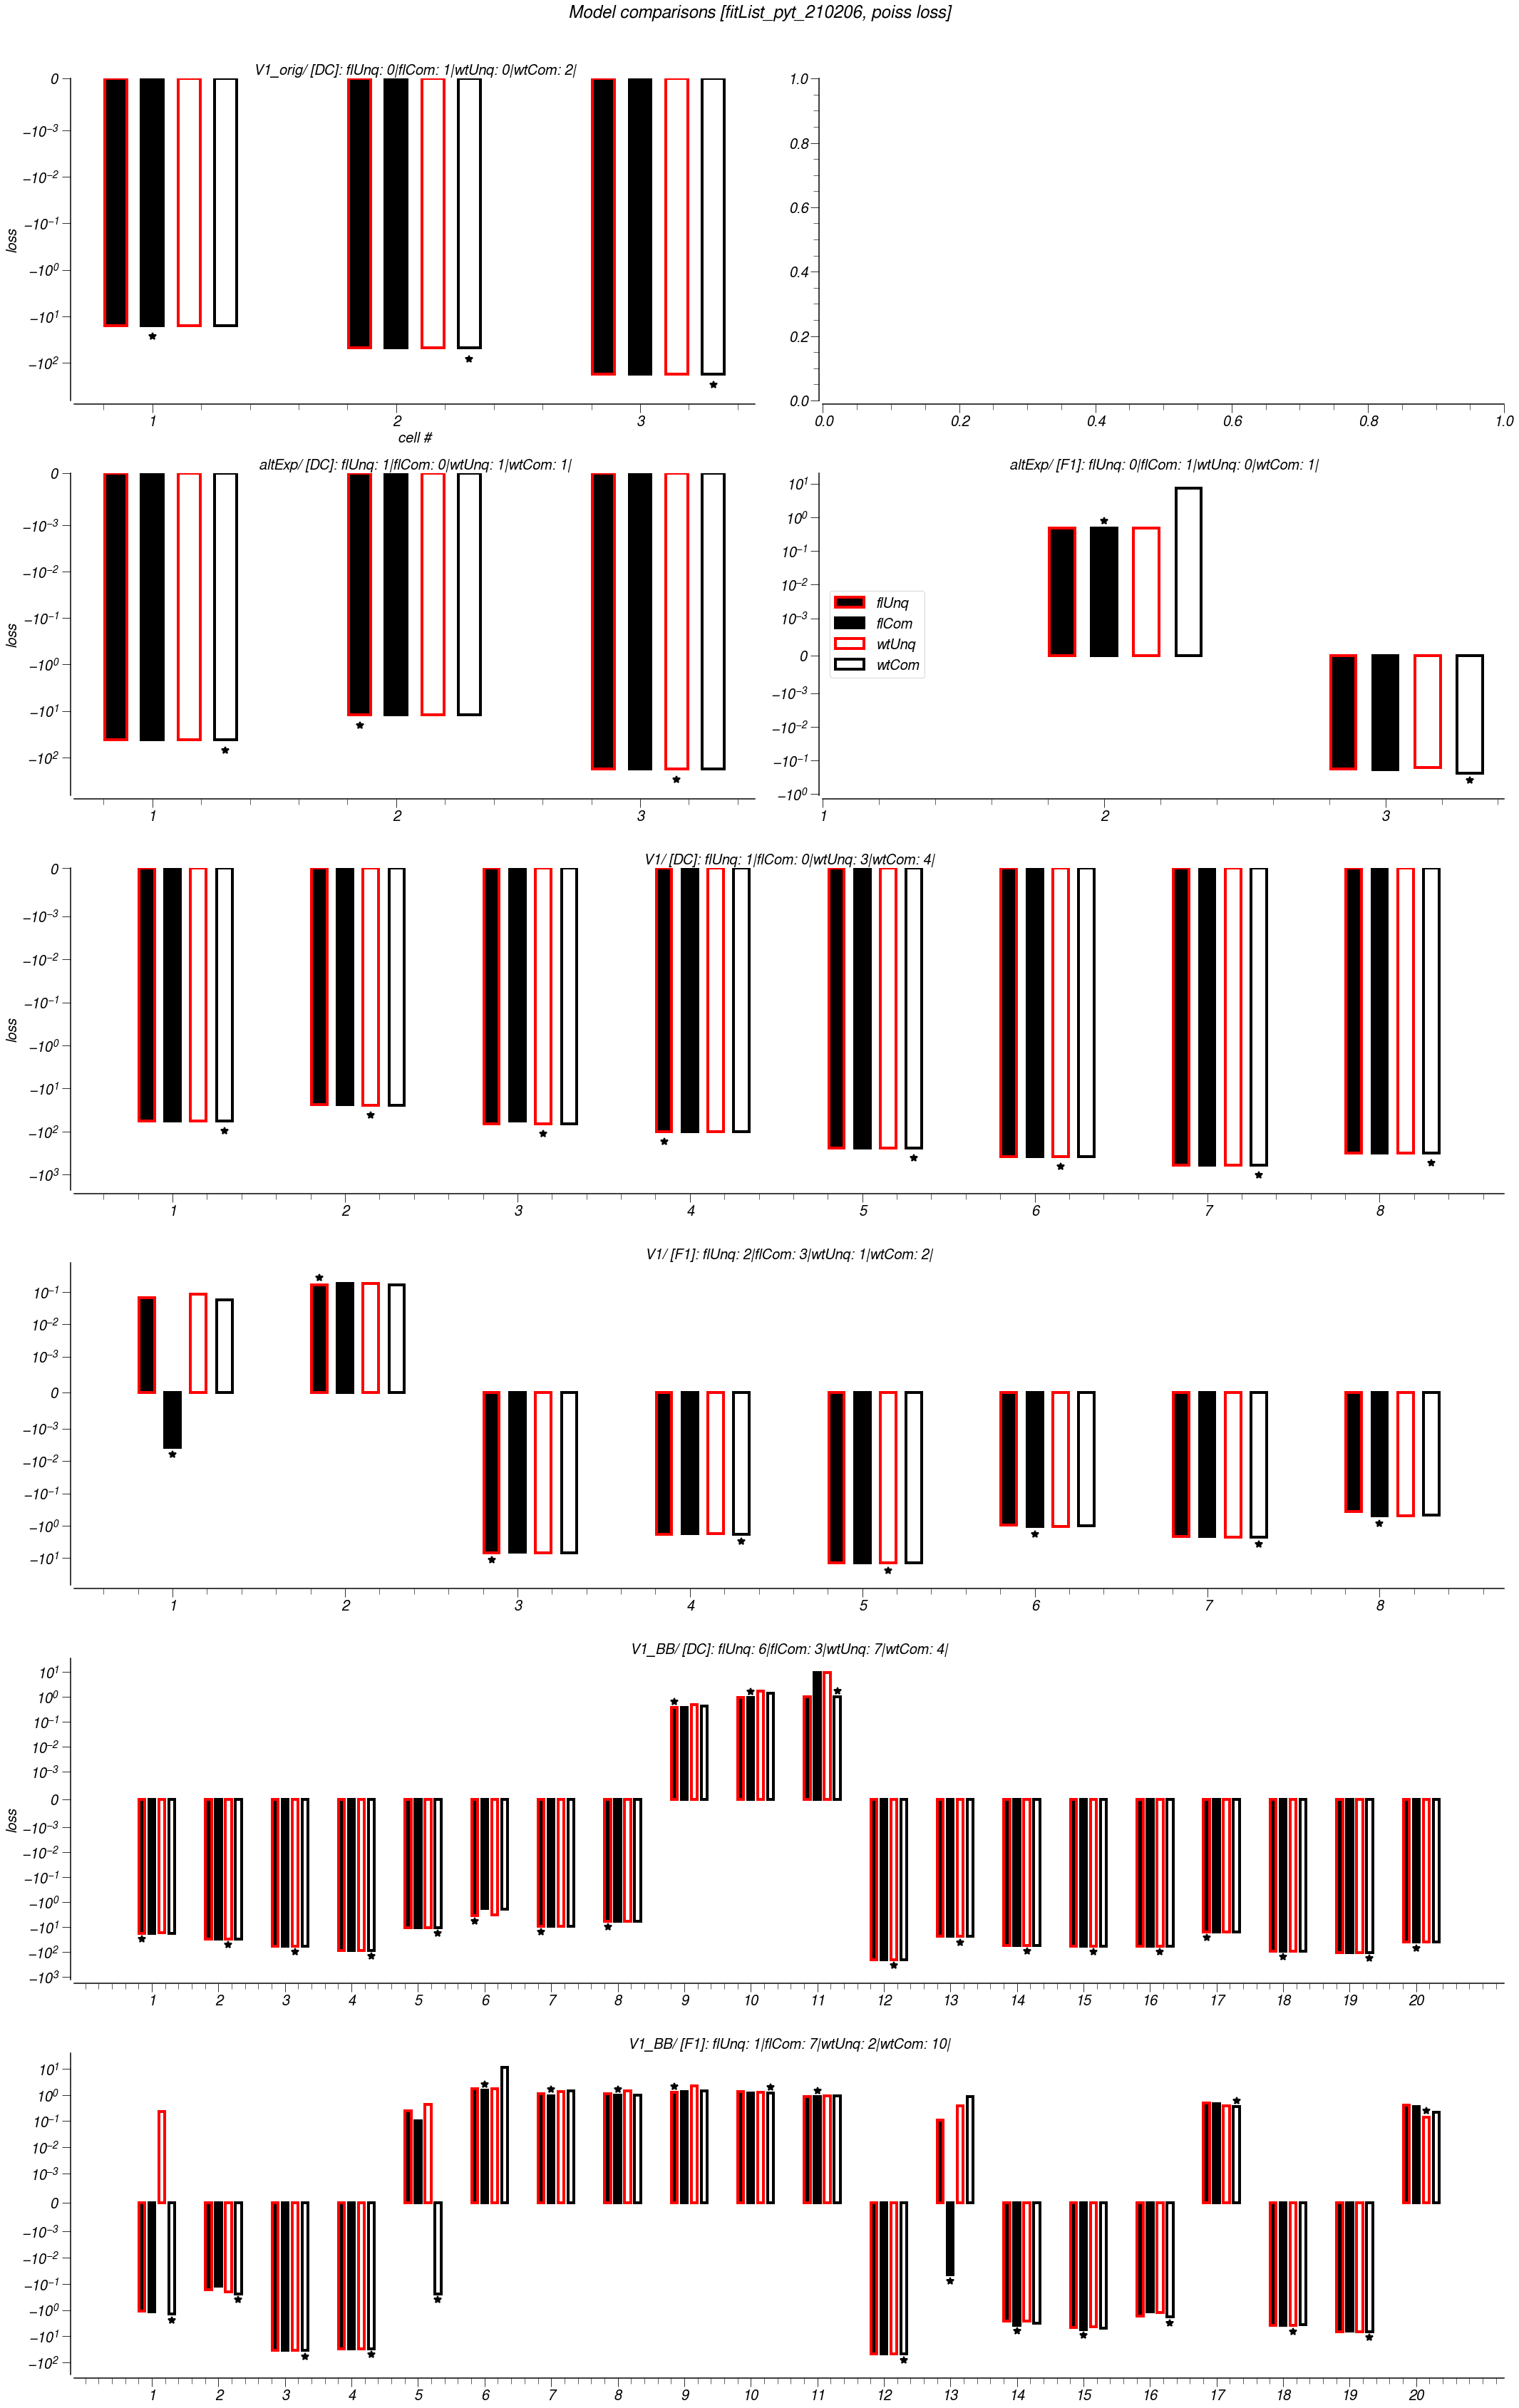

In [868]:
toNorm = 0;
ylab_suff = ' (% of lowest)' if toNorm else '';
    
# no need to adjust, really...
expDirs = ['V1_orig/', 'altExp/', 'V1/', 'V1_BB/']
nRow, nCol = 6, 2; # nExpDirs* x nMetrics // we add two extra rows since we'll split V1, V1_BB (too many cells for one panel)
f, ax = plt.subplots(nRow, nCol, figsize=(15*nCol, 8*nRow))
clr = ['k', 'w']; # flat, weighted
edgeClr = ['r', 'k']; # distinct, common
lineWidth = 4;
width = 0.09; # spacing of the bars
# lst = ['-', '--']; # distinct, common
min_thresh = 1e-3

nNorms, nCons = len(normTypes), len(lgnConType);

for (i, expDir), loss_perCond in zip(enumerate(expDirs), loss_all):

    nCells = loss_perCond.shape[0]; nConds = nNorms*nCons

    for metric, metLabel in enumerate(['DC', 'F1']):
        if nCells<6:
            plt.subplot(nRow, nCol, 1 + i*nCol + metric)
        else: # pretend there is only one column...
            plt.subplot(nRow, 1, -1 + i*nCol + metric)

        loss_reshape = np.reshape(loss_perCond[:,:,:,0,metric], (nCells, nConds));
        curr_mins = np.nanmin(loss_reshape, axis=1)
        if np.all(np.isnan(curr_mins)):
            continue; # then all the fits are invalid for this condition
            plt.axis_off();
        try:
            curr_mins_arg = np.nanargmin(loss_reshape, axis=1);
        except: # why? if a full row is NaN, then the try block won't work...
            curr_mins_arg = [np.nanargmin(x) if (~np.all(np.isnan(x))) else -1 for x in loss_reshape]

        # prepare on how to save the relevant information on which model is best for a given cell
        nBest = np.zeros((nConds, ), dtype='int')
        condStr = [];
    
        for ncI, normCurr in enumerate(normTypes):
            for ctI, conType in enumerate(lgnConType):

                curr_locs = 1+np.arange(nCells) - (1-ctI)*0.15 + ncI*0.3
                ind_1d = np.ravel_multi_index((ncI,ctI), (nNorms, nCons));
                which_min = np.where(curr_mins_arg == ind_1d)[0];
                nBest[ind_1d] = len(which_min)
                condStr.append('%s%s' % ('fl' if normCurr==1 else 'wt', 'Unq' if conType==1 else 'Com'))
                
                if toNorm:
                    plt.bar(curr_locs, 100*np.divide(loss_perCond[:,ncI,ctI,0,metric] - curr_mins, np.abs(curr_mins)), 
                                       color=clr[ncI], label=condStr[-1],
                                      lineWidth=lineWidth, edgeColor=edgeClr[ctI], width=width)
                    plt.ylim([-5e-3, 1e3])
                    plt.yscale('symlog', linthresh=1e-2)
                    
                    plt.plot(curr_locs[which_min], -2e-3*np.ones_like(which_min), '^',
                                 color='k', markersize=7) # just an indicator that this is the minimum loss
    
                else:
                    plt.bar(curr_locs, loss_perCond[:,ncI,ctI,0,metric], color=clr[ncI],
                                      label=condStr[-1], edgeColor=edgeClr[ctI], lineWidth=lineWidth, width=width)
                    plt.yscale('symlog', linthresh=1e-3)
                    plt.plot(curr_locs[which_min], 1.7*curr_mins[which_min], '*',
                                 color='k', markersize=10) # just an indicator that this is the minimum loss
                
        if metric==1 and i==1:
            plt.legend(loc='center left');
        if metric==0:
            plt.ylabel('loss%s' % ylab_suff);
            if i==0:
                plt.xlabel('cell #')
                    
        bestStr = ''.join(['%s: %d|' % (x,y) for x,y in zip(condStr, nBest)])
        plt.title('%s [%s]: %s' % (expDir, metLabel, bestStr))
        plt.xticks(ticks=1+np.arange(loss_perCond.shape[0]))
        sns.despine(offset=5)
                
f.suptitle('Model comparisons [%s, %s loss]' % (fitBase, loss_suff));
f.tight_layout()
f.subplots_adjust(top=0.95)

# now save
normSuff = '_norm' if toNorm else '';
currNm = 'modComparisons_%s_%s%s.pdf' % (fitBase, loss_suff, normSuff)
pdf = pltSave.PdfPages(str('%s%sfigures/%s' % (baseDir, expDir, currNm)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()


## Smarter initialization
In order to better initialize the parameters, let's plot the distribution of fitted parameters. If we see regions of best-fit parameters or patterns of successful parameters, then we can start our initialization there.  

##### Gather fit info

In [730]:
lossType = 1
lgnOn = 1

expDirs = ['V1_orig/', 'altExp/', 'V1/', 'V1_BB/']
lgnConType = [1,2]; # 1 is distinct M & P RVC channels, 2 is fixed, common RVC
lgnConLbls = ['sep', 'fix']

if excType == 2:
    if normType == 1:
        paramOrder = ['prefSf', 'sigLow', 'c50', 'respExp', 'respScale', 'noiseEarly', 'noiseLate', 'varGain', 'inhAsym', 'sigHigh', 'mWeight']
    if normType == 2:
        paramOrder = ['prefSf', 'sigLow', 'c50', 'respExp', 'respScale', 'noiseEarly', 'noiseLate', 'varGain', 'gs_mean', 'gs_std', 'sigHigh', 'mWeight']
    
    
allParams = None;
tot_count = 0;

for expDir in expDirs:
    
    dataList = hf.np_smart_load('%s%sstructures/%s' % (baseDir, expDir, hf.get_datalist(expDir)))
    nCells = len(dataList['unitName'])
    
    for lgnCon, lgnConLbl in zip(lgnConType, lgnConLbls):
        curr_name = hf.fitList_name(fitBase, normCurr, lossType, lgnType=lgnOn, lgnConType=lgnCon, vecCorrected=vecCorrected)
        curr_fit = hf.np_smart_load('%s%sstructures/%s' % (baseDir, expDir, curr_name))
        
        for cellNum in np.arange(1, nCells+1):
            for metric in np.arange(2):
                curr_metr = hf_sf.get_resp_str(metric)
                meta = [cellNum, expDir, hf.lossType_suffix(lossType).replace('_', '').replace('.npy', ''), curr_metr, lgnConLbl]
                meta_label = ['cell #', 'expDir', 'loss', 'metric', 'lgnCon']

                if allParams is None:
                    try:
                        allParams = pd.DataFrame(data=meta + curr_fit[cellNum-1][curr_metr]['params'], index=meta_label + paramOrder, columns=['%s_%s' % (dataList['unitName'][cellNum-1], curr_metr)])
                        tot_count += 1;
                    except: # if that particular fit is not there...
                        pass
                else:
                    try:
                        allParams.insert(loc=int(tot_count), column='%s_%s_%s' % (dataList['unitName'][cellNum-1], curr_metr, lgnConLbl), value=meta + curr_fit[cellNum-1][curr_metr]['params'])
                        tot_count += 1;
                    except:
                        pass

# Then, transpose at the end since it's easier to work with this way
allParams = allParams.transpose();
# ... and make all of the non-meta columns numeric (float)
nMeta = len(meta);
numeric_cols = allParams.columns[nMeta:]
allParams[numeric_cols] = allParams[numeric_cols].astype('float')



##### Excitatory filter

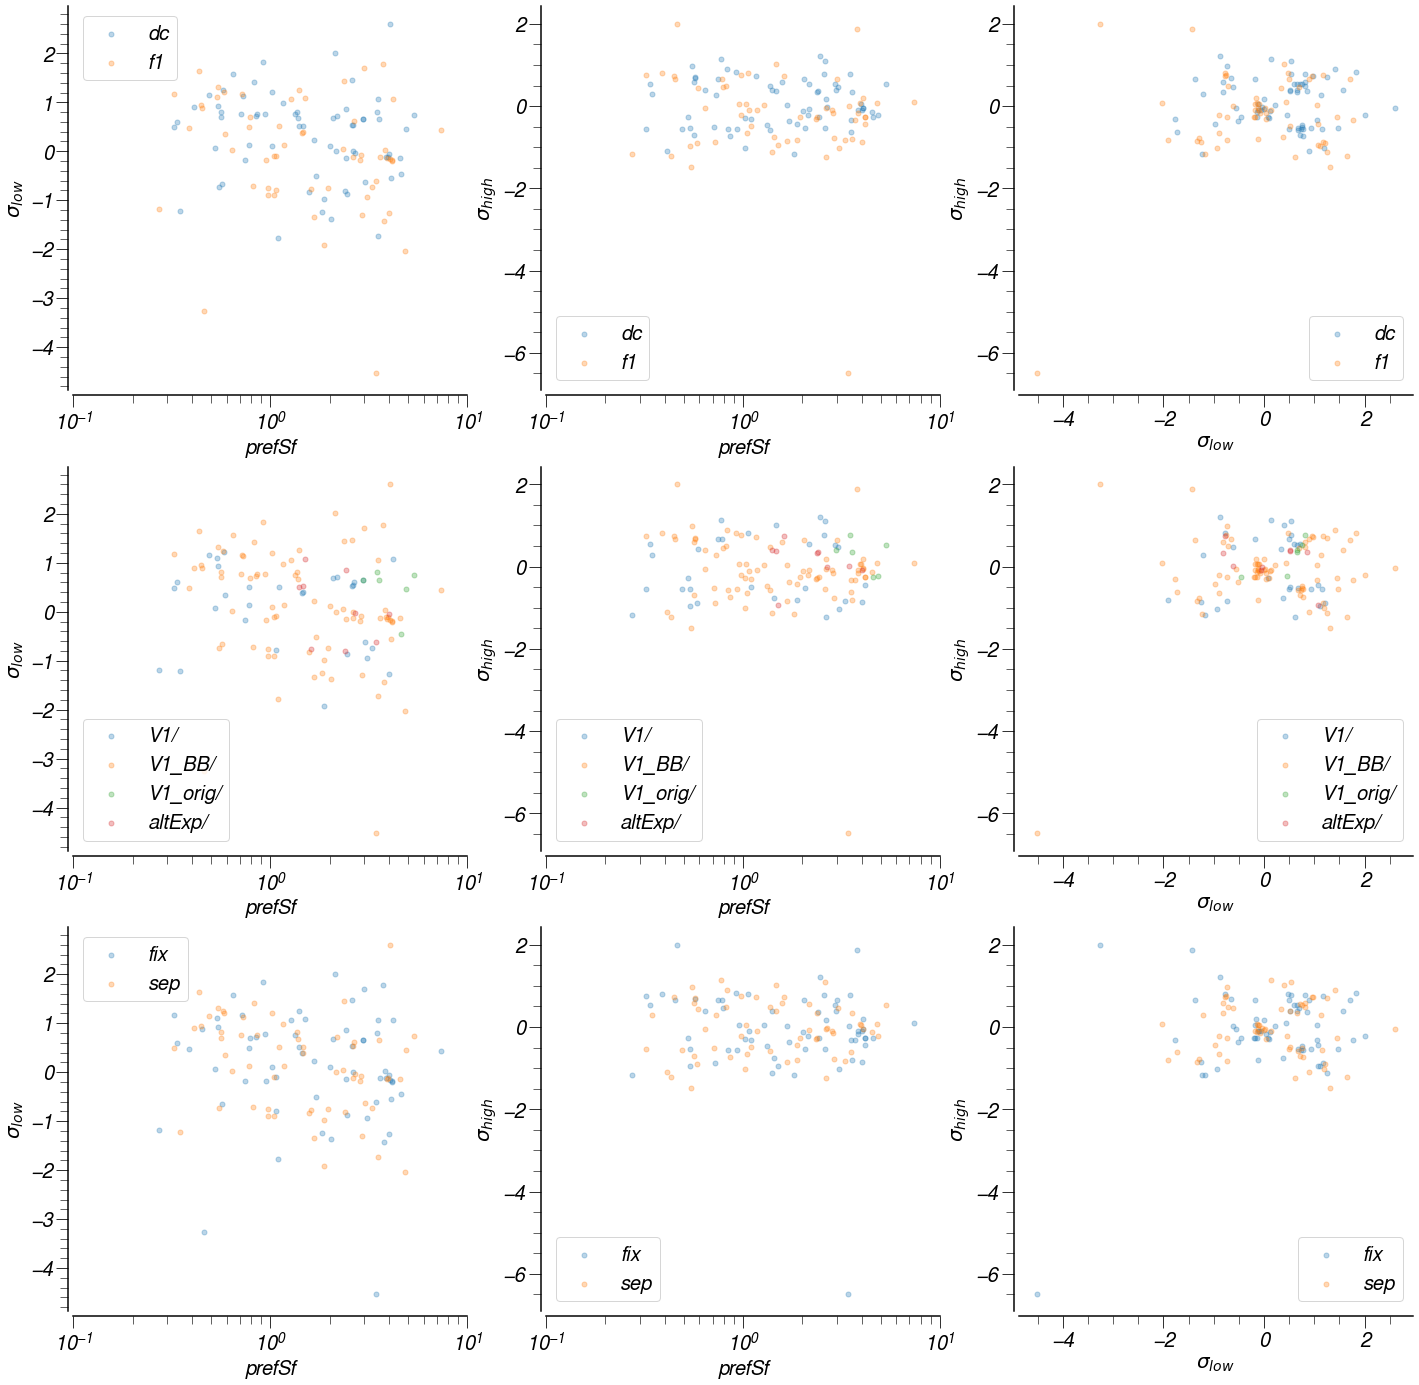

In [731]:
nrow, ncol = 3, 3
f, ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 8*nrow))

clr_resp = {'f1':'red', 'dc':'black'}
clr_expDir = {'V1_orig/': 'black', 'altExp/': 'black', 'V1/': 'blue', 'V1_BB/': 'red'} 
clr_lgnCon = {'sep':'black', 'fix':'red'}

for (i, clr), whichClr in zip(enumerate([clr_resp, clr_expDir, clr_lgnCon]), ['metric', 'expDir', 'lgnCon']):
    
    groups = allParams.groupby(whichClr)
    
    # prefSf vs. sigmaLow
    plt.subplot(nrow,ncol,1 + ncol*i)
    for name, group in groups:
        plt.scatter(group['prefSf'], group['sigLow'], label=name, alpha=0.3)
    plt.xscale('log')
    plt.xlabel('prefSf')
    plt.ylabel(r'$\sigma_{low}$')
    plt.xlim([0.1, 10])
    plt.legend();

    # prefSf vs. sigmaHigh
    plt.subplot(nrow,ncol,2 + ncol*i)
    for name, group in groups:
        plt.scatter(group['prefSf'], group['sigHigh'], label=name, alpha=0.3)
    plt.xlabel('prefSf')
    plt.ylabel(r'$\sigma_{high}$')
    plt.xscale('log')
    plt.xlim([0.1, 10])
    plt.legend();

    # sigmaLow vs. sigmaHigh
    plt.subplot(nrow,ncol,3 + ncol*i)
    for name, group in groups:
        plt.scatter(group['sigLow'], group['sigHigh'], label=name, alpha=0.3)
    plt.xlabel(r'$\sigma_{low}$')
    plt.ylabel(r'$\sigma_{high}$')
    plt.legend();

sns.despine(offset=5)

Thankfully, the distribution of excitatory filter parameters seems invariant to all three tested "slices" of model fits:
- whether the fits are to DC or F1 responses
- which experiment the fits are from
- whether or not the LGN contrast is fixed for both channels (i.e. M&P) or separate. Likewise for pref

Thus, we can just choose an initialization range from the above distributions and have it apply to all fits.


##### Scalars, output non-linearity

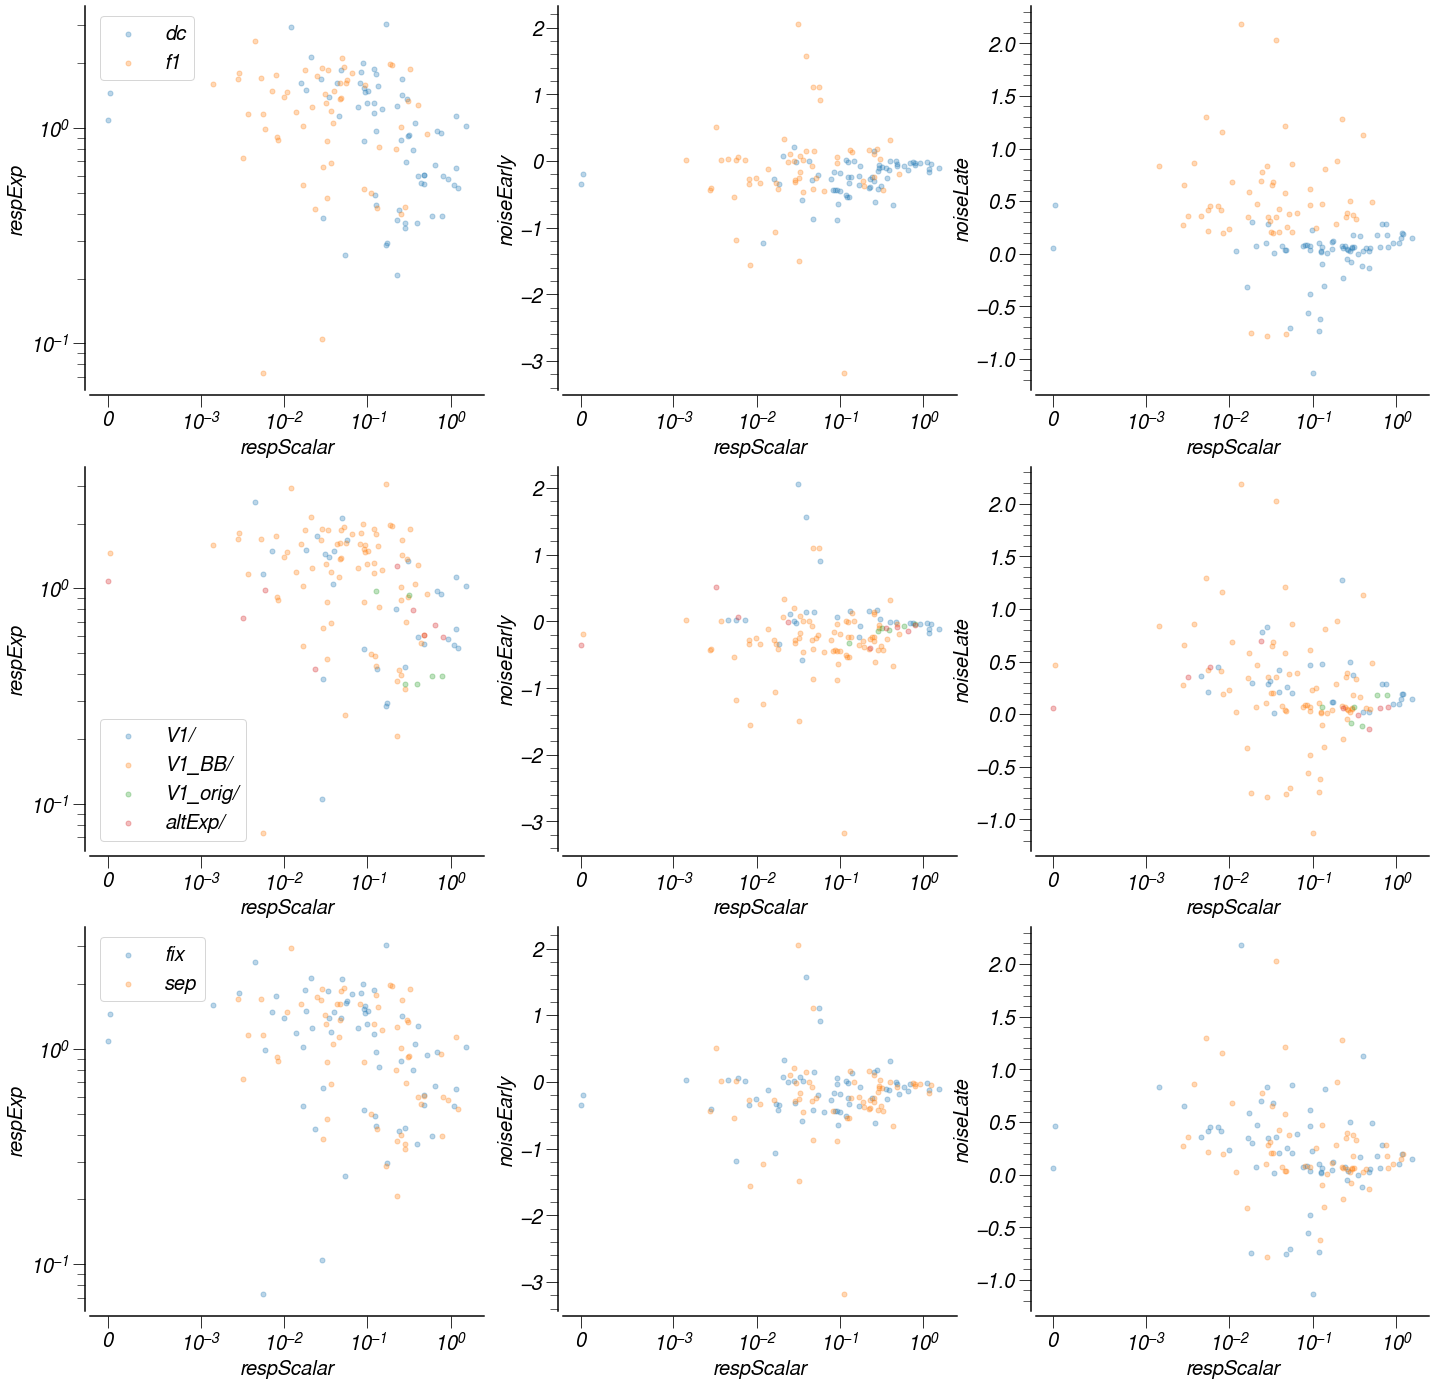

In [869]:
nrow, ncol = 3, 3
f, ax = plt.subplots(nrow, ncol, figsize=(8*ncol, 8*nrow))

clr_resp = {'f1':'red', 'dc':'black'}
clr_expDir = {'V1_orig/': 'black', 'altExp/': 'black', 'V1/': 'blue', 'V1_BB/': 'red'} 
clr_lgnCon = {'sep':'black', 'fix':'red'}

for (i, clr), whichClr in zip(enumerate([clr_resp, clr_expDir, clr_lgnCon]), ['metric', 'expDir', 'lgnCon']):
    
    groups = allParams.groupby(whichClr)
    
    # respScalar vs. respExp
    plt.subplot(nrow,ncol,1 + ncol*i)
    for name, group in groups:
        plt.scatter(np.abs(group['respScale']), group['respExp'], label=name, alpha=0.3)
    plt.xlabel('respScalar')
    plt.ylabel('respExp')
    plt.xscale('symlog', linthresh=1e-3)
    plt.yscale('log')
    plt.legend();

    # respScalar vs. noiseEarly
    plt.subplot(nrow,ncol,2 + ncol*i)
    for name, group in groups:
        plt.scatter(np.abs(group['respScale']), group['noiseEarly'], label=name, alpha=0.3)
    plt.xscale('symlog', linthresh=1e-3)
    plt.xlabel('respScalar')
    plt.ylabel('noiseEarly')

    # respScalar vs. noiseLate
    plt.subplot(nrow,ncol,3 + ncol*i)
    for name, group in groups:
        plt.scatter(np.abs(group['respScale']), group['noiseLate'], label=name, alpha=0.3)
    plt.xscale('symlog', linthresh=1e-3)
    plt.xlabel('respScalar')
    plt.ylabel('noiseLate')

sns.despine(offset=5)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


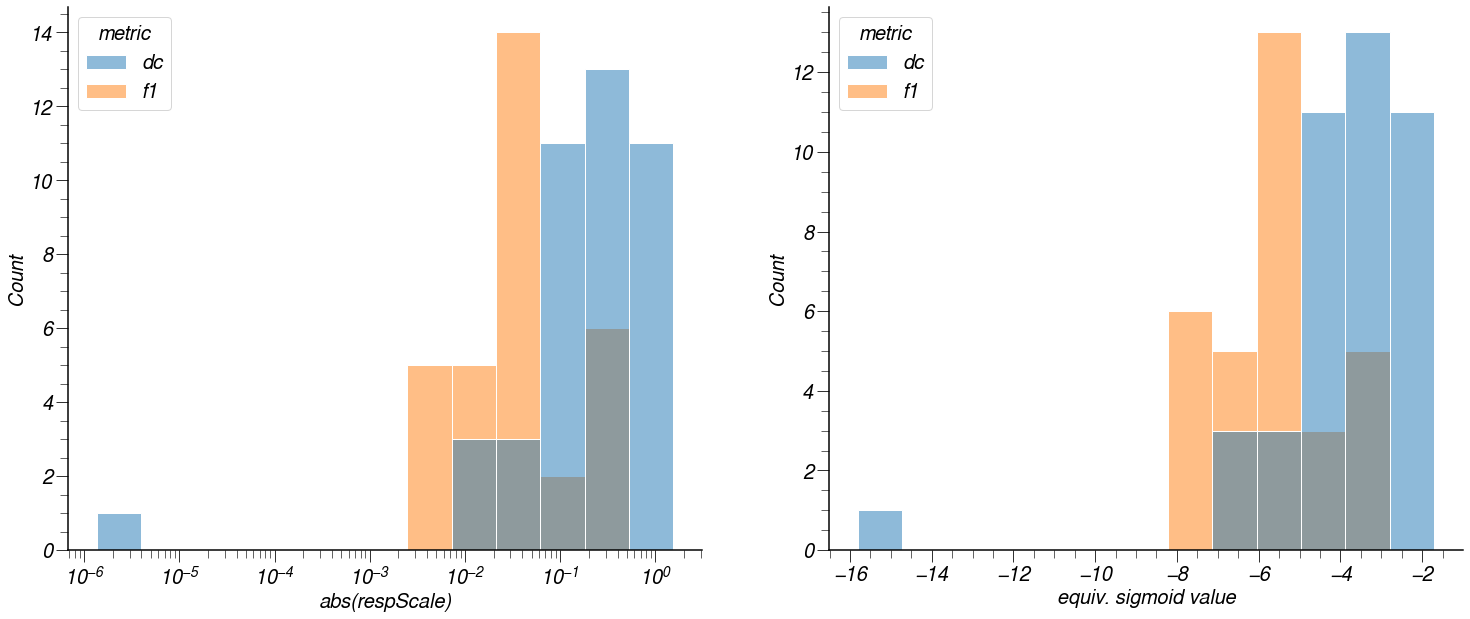

In [907]:
f, ax = plt.subplots(1, 2, figsize=(25, 10))

sns.histplot(allParams, x='respScale', hue='metric', legend='metric', log_scale=True, ax=ax[0])
ax[0].set_xlabel('abs(respScale)');

xHat = -np.log((10-allParams['respScale'])/allParams['respScale'])
allParams['respScalePrime'] = xHat;
sns.histplot(allParams, x='respScalePrime', hue='metric', ax=ax[1])
ax[1].set_xlabel('equiv. sigmoid value');


Here, we _do_ see a separation in fit parameters for specific model configurations. Most notably, the response scalar values are larger for DC than F1 responses - we can build this into the initialization routine. Otherwise, the distributions suggest a common initialization is acceptable. But let's take a closer look with just the distributions rather than the 2D scatter plots.


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


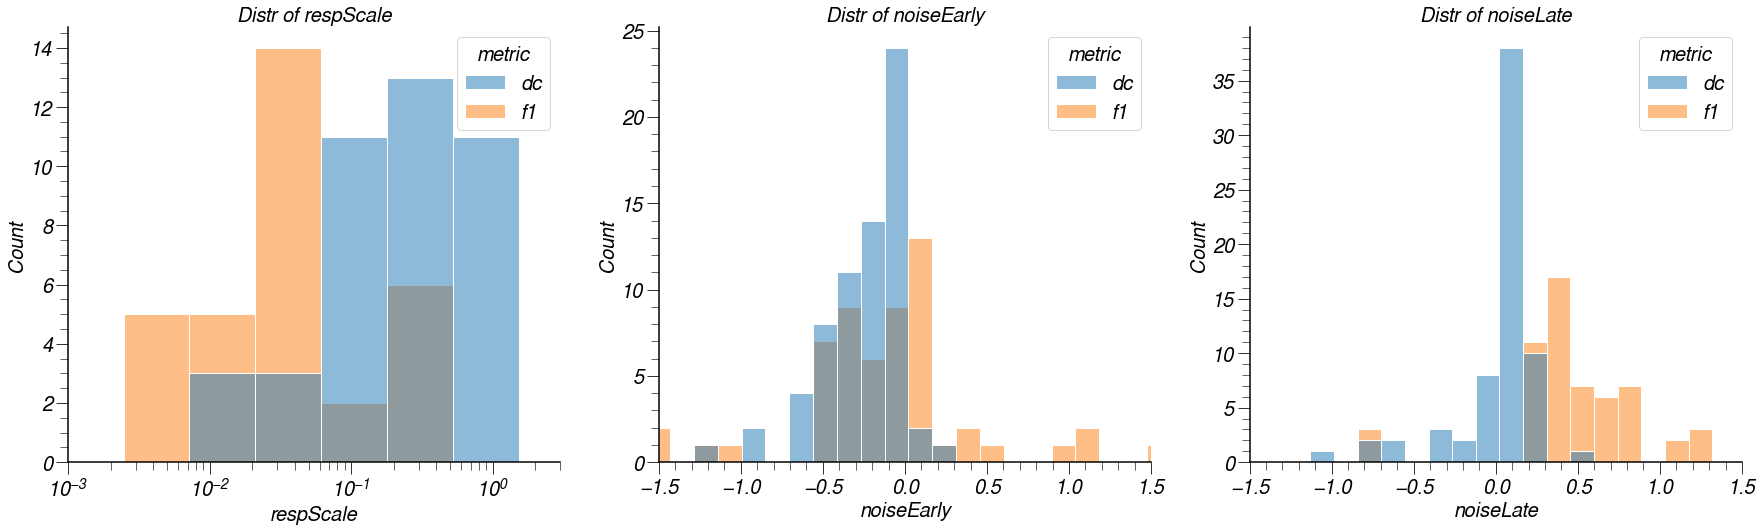

In [744]:
nrow, ncol = 1,3
f, ax = plt.subplots(nrow,ncol,figsize=(10*ncol, 8*nrow))

params = ['respScale', 'noiseEarly', 'noiseLate'];
xlims = [[1e-3, 3], [-1.5,1.5], [-1.5,1.5]]
for (i, prm), xlim in zip(enumerate(params), xlims):

    groups = allParams.groupby('metric')

    plt.subplot(nrow, ncol, i+1)
    if prm == 'respScale': # take abs...
        sns.histplot(allParams, x=prm, hue='metric', legend='metric', log_scale=True)
    else:
        sns.histplot(allParams, x=prm, hue='metric', legend='metric')
    plt.title('Distr of %s' % prm)
    plt.xlim(xlim)
#     plt.legend()


We recapitulate the separation of response scalar best fits by DC, F1, but also show a slight shift in the distributions for early and late noise based on DC or F1 - let's build this in to the initialization.

##### Gain control

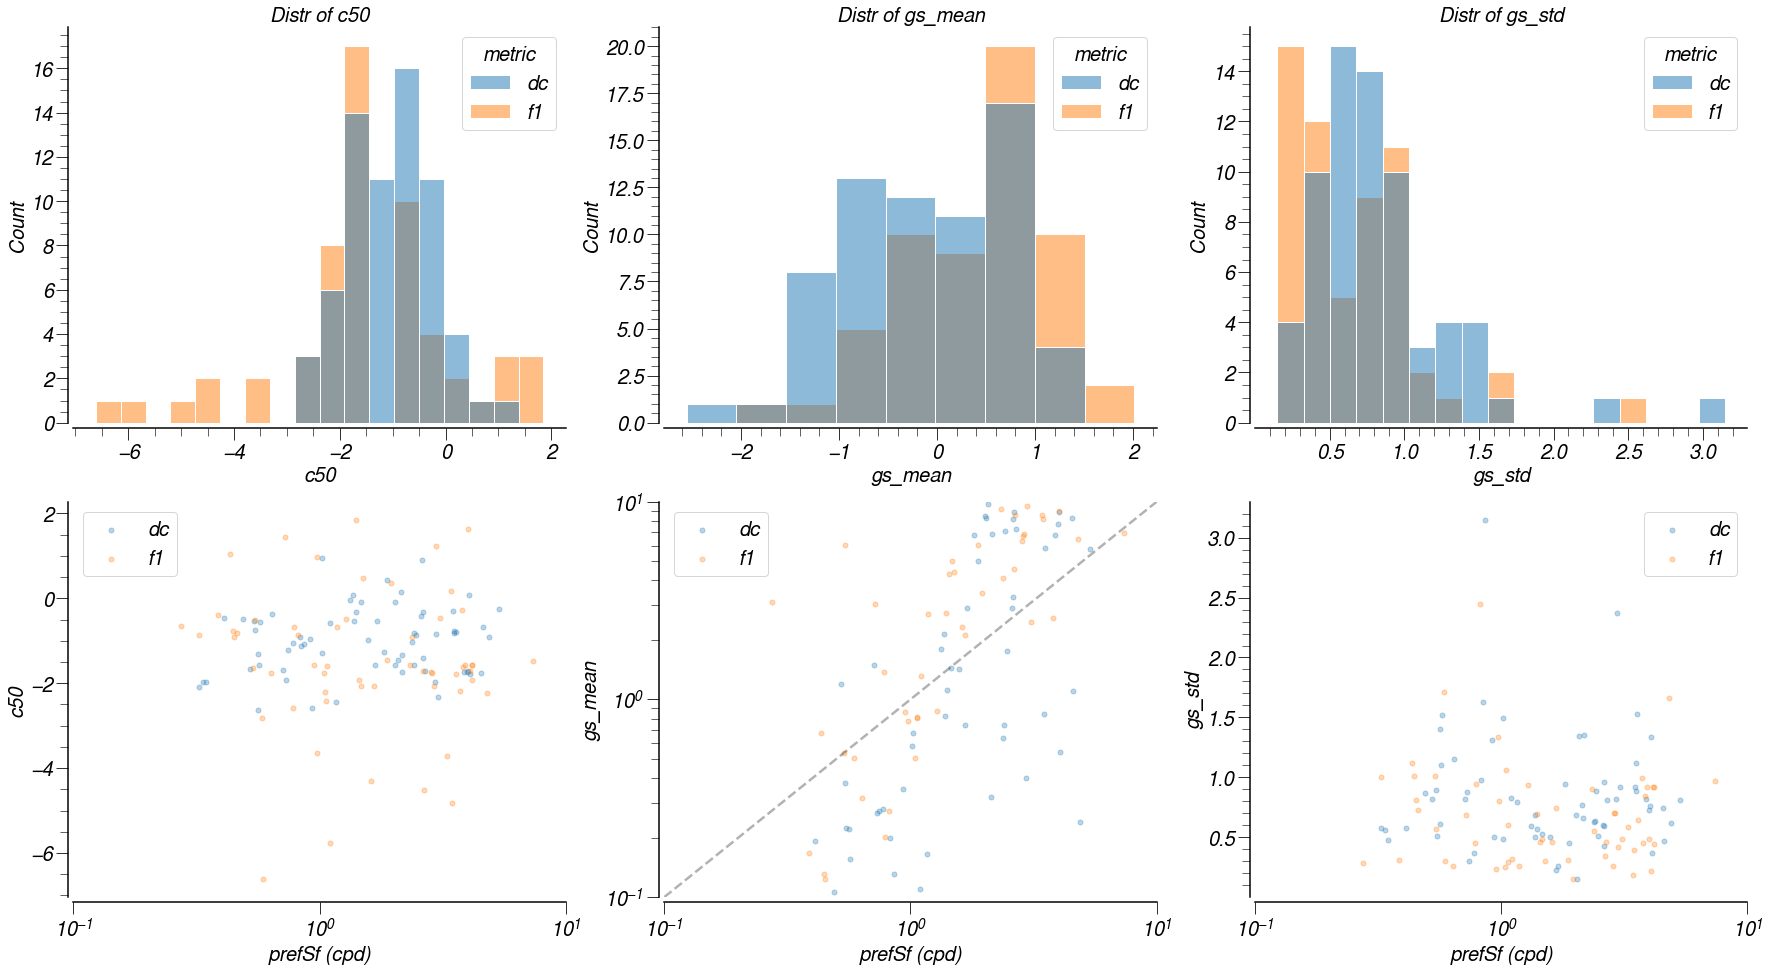

In [757]:
nrow, ncol = 2,3
f, ax = plt.subplots(nrow,ncol,figsize=(10*ncol, 8*nrow))

params = ['c50', 'gs_mean', 'gs_std'];
grouping = 'metric'


# xlims = [[1e-3, 3], [-1.5,1.5], [-1.5,1.5]]
# for (i, prm), xlim in zip(enumerate(params), xlims):
for i, prm in enumerate(params):

    ### first as distributions

    plt.subplot(nrow, ncol, i+1)
    sns.histplot(allParams, x=prm, hue=grouping, legend=grouping)
    plt.title('Distr of %s' % prm)
#     plt.xlim(xlim)
#     plt.legend()

    ### then as comparisions vs. prefSf
    groups = allParams.groupby(grouping)
    
    # respScalar vs. "prm"
    plt.subplot(nrow, ncol, 1+ncol+i)
    for name, group in groups:
        if prm == 'gs_mean':
            plt.scatter(np.abs(group['prefSf']), np.power(10, group[prm]), label=name, alpha=0.3)
        else:
            plt.scatter(np.abs(group['prefSf']), group[prm], label=name, alpha=0.3)
    plt.xlabel('prefSf (cpd)')
    plt.ylabel(prm)
    if prm == 'gs_mean':
        plt.yscale('log')
        plt.ylim([0.1, 10])
        plt.plot([0.1, 10], [0.1, 10], 'k--', alpha=0.3)

    plt.xscale('symlog', linthresh=1e-3)
    plt.xlim([0.1, 10])
#     plt.yscale('log')
    plt.legend();

sns.despine(offset=5)

Here, the distributions are relatively invariant to specific model configuration (we can comfortably look at just DC vs F1, rather than trying to look at which experiment or which LGN contrast front-end)

TODO: Reformulate sigLow, sigHigh, and respScalar so they are never negative (currently we _abs_ respScalar, and technically, a negative sig* shouldn't matter, since it's always squared)

## Tuned vs Untuned (OLD)

TODO: Fix issue in analyzeEval.compute_diffs

After presenting my work in an LCV meeting, Tim (Oleskiw) made some suggestions for how to compare two forms of my model. In one form, the normalization is flat over all spatial frequency, while in the other, there is a "tuning" to the normalization pool. In the language of a contrast gain control model, the stimulus energy for particular spatial frequencies is weighted more than stimulus (or contrast) energy in other portions of the frequency spectrum. In the current formulation, the weight of each filter in the normalization pool is weighted according to its position along the weighting function - a two-halved log-Gaussian with an offset. I.e., the weight of each filter is the sum of some overall offest plus the value of the weighting function evaluated at the filter's preferred frequency. 

To compare the models, we hold out one of the N conditions in the experiment (here N is 110, from 5 dispersions with 2 contrasts at 11 spatial frequency centers). Optimize each model for the N-1 conditions and evalulate both the overall loss, and the prediction error on the held out condition. Do this for all N conditions, and compare between the two models

In [ ]:
lossType = 4; # 1 - sqrt, 2 - poiss, 3 - modPoiss, 4 - chiSq
expInd = 1; # V1; altExp (V1); LGN
_, _, _, _, flat, weight = analyzeEval.compute_diffs(lossType, expInd=expInd, date='181129')
# diffs_loss, diffs_pred, losses, preds, flat, weight = analyzeEval.compute_diffs(lossType, expInd=expInd, date='181129')

if lossType == 1:
     lossStr = 'sqrt'
elif lossType == 2:
     lossStr = 'poiss'
elif lossType == 3:
     lossStr = 'modPoiss'

In [ ]:
diffs_loss_all = diffs_loss.flatten();
diffs_pred_all = diffs_pred.flatten();

#### Analysis for when we hold out all Sfs for given con X disp

The analysis for holding out individual SFs is below

In [ ]:
nCells = 59; nDisps = 5; nCons = 2;
holdNLL = dict();

NLL        = np.nan * np.zeros((nCells, nDisps, nCons, 2));
holdoutNLL = np.nan * np.zeros((nCells, nDisps, nCons, 2));
for i in range(nCells):
    if i in flat:
        NLL[i, :, :, 0] = flat[i]['NLL']
        holdoutNLL[i, :, :, 0] = flat[i]['holdoutNLL']
    if i in weight:
        NLL[i, :, :, 1] = weight[i]['NLL']
        holdoutNLL[i, :, :, 1] = weight[i]['holdoutNLL']
        
diffs = dict();
diffs['NLL'] = NLL[:, :, :, 0] - NLL[:, :, :, 1]
diffs['holdoutNLL'] = holdoutNLL[:, :, :, 0] - holdoutNLL[:, :, :, 1]

dn_flattened = diffs['NLL'].flatten();
dh_flattened = diffs['holdoutNLL'].flatten();

In [ ]:
nRows = 1;
nCols = 3;
f, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 10*nRows))

nSteps = 21;
bins = np.linspace(-0.2, 0.2, nSteps)
width = 0.8*np.ptp(bins)/nSteps # ptp is np.max - np.min
## ALL CONDITIONS

# just loss
plt.subplot(nRows, nCols, 1)
non_nan_nll = dn_flattened[~np.isnan(dn_flattened)];
counts, _ = np.histogram(non_nan_nll, bins=bins)
counts_norm = counts/len(non_nan_nll)
plt.bar(bins[0:-1], counts_norm, width=width, align='edge')
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan_nll), 1.1*np.max(counts_norm), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Loss (mu/med): %.4f // %.4f' % (np.mean(non_nan_nll), np.median(non_nan_nll)))

# just prediction error
plt.subplot(nRows, nCols, 2)
non_nan_hold = dh_flattened[~np.isnan(dh_flattened)];
counts, _ = np.histogram(non_nan_hold, bins=bins)
counts_norm = counts/len(non_nan_hold)
plt.bar(bins[0:-1], counts_norm, width=width, align='edge')
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan_hold), 1.1*np.max(counts_norm), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Pred (mu/med): %.4f // %.4f' % (np.mean(non_nan_hold), np.median(non_nan_hold)))

# expanded
plt.subplot(nRows, nCols, 3)
plt.scatter(dn_flattened, dh_flattened, alpha=0.4);
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')
plt.plot(np.nanmean(non_nan_nll), np.nanmean(non_nan_hold), 'o', color='k')
plt.xlabel('flat loss - tuned loss');
plt.ylabel('flat pred - tuned pred');
plt.axis('equal');


In [ ]:
nRows = 2;
nCols = 3;
f, ax = plt.subplots(nRows, nCols, figsize=(12*nCols, 10*nRows))

bins = np.linspace(-0.2, 0.2, 21)

## ALL CONDITIONS

# just loss
plt.subplot(nRows, nCols, 1)
non_nan = diffs_loss_all[~np.isnan(diffs_loss_all)];
n, _, _ = plt.hist(non_nan, bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Loss (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# just prediction error
plt.subplot(nRows, nCols, 2)
non_nan = diffs_pred_all[~np.isnan(diffs_pred_all)];
n, _, _ = plt.hist(diffs_pred_all[~np.isnan(diffs_pred_all)], bins=bins)
plt.axvline(0, ls='--')
plt.plot(np.median(non_nan), 1.1*np.max(n), 'v', markersize=25, color='k')
plt.xlabel('flat - tuned')
plt.title('Pred (mu/med): %.4f // %.4f' % (np.mean(non_nan), np.median(non_nan)))

# expanded
plt.subplot(nRows, nCols, 3)
plt.scatter(diffs_loss_all, diffs_pred_all, alpha=0.4);
plt.axhline(0, ls='--')
plt.axvline(0, ls='--')
plt.plot(np.nanmean(diffs_loss_all), np.nanmean(diffs_pred_all), 'o', color='k')
plt.xlabel('flat loss - tuned loss');
plt.ylabel('flat pred - tuned pred');
plt.axis('equal');

## SLICES (e.g. by cell)
# by contrast
plt.subplot(nRows, nCols, 4)
high_con = [0, 0, 0]; low_con = [0.5, 0.5, 0.5];
colors = [high_con, low_con];
mark_size = 20;

for i in range(2): # 2 contrasts

    loss_curr = diffs_loss[:, :, i].flatten()
    plt.plot(i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    
    pred_curr = diffs_pred[:, :, i].flatten()
    plt.plot(i + 2.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2 + i, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i])

plt.legend(fontsize='small');
plt.title('by contrast')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(4), ('loss high', 'loss low', 'pred high', 'pred low'))
plt.ylabel('flat - tuned');
# plt.axis('equal');

# by dispersion
plt.subplot(nRows, nCols, 5)
nDisps = 5;
colors = cm.viridis(np.linspace(0, 0.8, nDisps))
mark_size = 20;

for i in range(nDisps):

    loss_curr = diffs_loss[:, i, :].flatten()
    plt.plot(2*i + 0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=colors[i], label='%.3f' % np.nanmean(loss_curr))
    plt.scatter(np.random.normal(loc=2*i, scale=0.1, size=loss_curr.shape), loss_curr, color=colors[i])
    pred_curr = diffs_pred[:, i, :].flatten()
    plt.plot(2*i + 1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=colors[i], alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
    plt.scatter(np.random.normal(loc=2*i+1, scale=0.1, size=pred_curr.shape), pred_curr, color=colors[i], alpha=0.4)

plt.legend(fontsize='small');
plt.title('by dispersion')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)

# by cell
plt.subplot(nRows, nCols, 6)
mark_size = 20;

loss_curr = np.nanmean(np.nanmean(diffs_loss, 1), 1);
plt.plot(0.4, np.nanmean(loss_curr), '<', markersize=mark_size, color=high_con, label='%.3f' % np.nanmean(loss_curr))
plt.scatter(np.random.normal(loc=0, scale=0.1, size=loss_curr.shape), loss_curr, color=high_con)
pred_curr = np.nanmean(np.nanmean(diffs_pred, 1), 1);
plt.plot(1.4, np.nanmean(pred_curr), '<', markersize=mark_size, color=high_con, alpha=0.4, label='%.3f' % np.nanmean(pred_curr))
plt.scatter(np.random.normal(loc=1, scale=0.1, size=pred_curr.shape), pred_curr, color=high_con, alpha=0.4)

plt.legend(fontsize='small');
plt.title('by cell')
plt.axhline(0, ls='--', color='k')
plt.xticks(np.arange(2), ('loss', 'prediction'), rotation=45)


plt.suptitle('Comparing models: %s loss' % lossStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

## Chi squared interlude

First, let's ask which version of the fit is better? "c" was long-ago (i.e. lead up to VSS abstract) determined to be better. But should we re-evaluate?


In [ ]:
lossType = 4;
verSuffix = ['z005', 'a', 'b', 'c'];
verK      = [0.005, 0.01, 0.05, 0.1];
# baseStr = 'fitListSPcns_181130';
baseStr = 'fitList_190613';
expDir = 'V1_orig/'

if lossType == 1:
    lossStr = '_sqrt'
elif lossType == 2:
    lossStr = '_poiss'
elif lossType == 3:
    lossStr = '_modPoiss'
elif lossType == 4:
    lossStr = '_chiSq'

chiSq = dict();

for ver in verSuffix:
    flatNm = str(baseStr + ver + '_flat' + lossStr + '.npy')
    wghtNm = str(baseStr + ver + '_wght' + lossStr + '.npy')

    chiFlat = hf.np_smart_load('%sstructures/' % expDir + flatNm)
    chiWght = hf.np_smart_load('%sstructures/' % expDir + wghtNm)
    
    chiCurr = dict();
    
    nCells = np.maximum(len(chiFlat.keys()), sorted(chiFlat.keys())[-1]+1);

    flat = np.nan * np.zeros((nCells, ))
    wght = np.nan * np.zeros((nCells, ))
    prms_flat = np.nan * np.zeros((nCells, ), dtype='O')
    prms_wght = np.nan * np.zeros((nCells, ), dtype='O')
    
    for i in range(nCells):
        if i in chiFlat:
            flat[i] = chiFlat[i]['NLL']
            prms_flat[i] = chiFlat[i]['params']
        if i in chiWght:
            wght[i] = chiWght[i]['NLL']
            prms_wght[i] = chiWght[i]['params']

    chiCurr['flat'] = flat
    chiCurr['wght'] = wght
    chiCurr['prms_flat'] = prms_flat
    chiCurr['prms_wght'] = prms_wght
    
    chiSq[ver] = chiCurr;

In [ ]:
flat_mins = np.argmin([chiSq[verSuffix[i]]['flat'] for i in range(len(verSuffix))], axis=0)
wght_mins = np.argmin([chiSq[verSuffix[i]]['wght'] for i in range(len(verSuffix))], axis=0)

In [ ]:
bins = np.arange(len(verSuffix)+1)
flat_winner = np.histogram(flat_mins, bins=bins)[0];
wght_winner = np.histogram(wght_mins, bins=bins)[0];

In [ ]:
colors = ['r', 'g', 'b', 'k']
f, ax = plt.subplots(2, 1, figsize=(20, 12))

# flat first
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, flat_winner)]
[ax[0].plot(1+np.arange(nCells), chiSq[ver]['flat'], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[0].set_title('Flat')
# ax[0].set_xlabel('cell #')
ax[0].set_ylabel(r'$\chi^2$')
ax[0].legend();

# then weighted
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, wght_winner)]
[ax[1].plot(1+np.arange(nCells), chiSq[ver]['wght'], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[1].set_title('Weighted')
ax[1].set_xlabel('cell #')
ax[1].set_ylabel(r'$\chi^2$')
ax[1].legend();

f.suptitle('Comparing k multiplier for best loss function %s' % baseStr);

sns.despine(offset=5);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompareLoss-%s%s.pdf' % (baseStr, lossStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

But, is this the correct analysis? The form of the $\chi^2$ loss function means that a higher "k" multiplier will result in a lower loss in cases with exactly equal model predictions. To remedy this, we should evaluate the same model fits with a different loss function - one which does not involve the multiplier under consideration. After all, our goal is to find the model optimization with the best fit to the data - not the lowest loss value, per se!

So now, let's take the same model parameters, but evaluate on a separate loss function (e.g. poisson).

**WARNING:** SLOW

In [ ]:
# first, we'll need to load dataList
dL_name = 'dataList.npy'
data_loc = '%sstructures/' % expDir;
dataList = hf.np_smart_load(data_loc + dL_name)
# and choose the loss we want to evaluate
check_lossType = 3; # poiss (2); chiSq (4); sqrt(1); modPoiss (3)

all_loss = dict();
for ver in verSuffix:
    print('evaluating new loss for suffix %s' % ver)
    curr_flat, curr_wght = chiSq[ver]['prms_flat'], chiSq[ver]['prms_wght']
    
    curr_loss = np.zeros((nCells, 2)); # nCells x flat/wght
    for i in range(nCells):
        try:
            expInd = hf.get_exp_ind(data_loc, dataList['unitName'][i])[0]

            curr_cell = hf.np_smart_load(data_loc + dataList['unitName'][i] + '_sfm.npy');
            trial_inf = curr_cell['sfm']['exp']['trial'];

            # now, mask! (needed for proper loss calculation)
            stimOr = trial_inf['ori']
            mask = np.isnan(np.sum(stimOr, 0));
            if expInd == 1:
                # get rid of orientation tuning curve trials                                                                                                                                                          
                oriBlockIDs = np.hstack((np.arange(131, 155+1, 2), np.arange(132, 136+1, 2))); # +1 to include endpoint like Matlab                                                                                   
                oriInds = np.empty((0,));
                for iB in oriBlockIDs:

                    indCond = np.where(trial_inf['blockID'] == iB);
                    if len(indCond[0]) > 0:
                        oriInds = np.append(oriInds, indCond);

                mask[oriInds.astype(np.int64)] = True; # as in, don't include those trials either!  

            ## now evaluate loss
            ls_flat = mod_resp.SFMGiveBof(curr_flat[i], curr_cell, normType=1, lossType=check_lossType, expInd=expInd, maskIn=~mask)[0];
            ls_wght = mod_resp.SFMGiveBof(curr_wght[i], curr_cell, normType=2, lossType=check_lossType, expInd=expInd, maskIn=~mask)[0];

#             print('for cell %d+1, flat/wght is %.2f/%.2f' % (i, ls_flat, ls_wght))
        except: # bad data structure or no/bad/nan fit
            ls_flat, ls_wght = np.nan, np.nan

        curr_loss[i] = [ls_flat, ls_wght]
        
    all_loss[ver] = curr_loss;

In [ ]:
# as before, determine the winners
flat_mins = np.argmin([all_loss[verSuffix[i]][:, 0] for i in range(len(verSuffix))], axis=0)
wght_mins = np.argmin([all_loss[verSuffix[i]][:, 1] for i in range(len(verSuffix))], axis=0)

bins = np.arange(len(verSuffix)+1)
flat_winner = np.histogram(flat_mins, bins=bins)[0];
wght_winner = np.histogram(wght_mins, bins=bins)[0];

In [ ]:
# now plot!

colors = ['r', 'g', 'b', 'k']
f, ax = plt.subplots(2, 1, figsize=(20, 12))

# flat first
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, flat_winner)]
[ax[0].plot(1+np.arange(nCells), all_loss[ver][:, 0], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[0].set_title('Flat')
# ax[0].set_xlabel('cell #')
ax[0].set_ylabel(r'$\chi^2$')
ax[0].legend();

# flat first
verLabels = ['k: %s - %d' % (label, times) for label, times in zip(verK, wght_winner)]
[ax[1].plot(1+np.arange(nCells), all_loss[ver][:, 1], '%so' % c, alpha=0.5, label=s) for ver,c,s in zip(verSuffix, colors, verLabels)];
ax[1].set_title('Weighted')
ax[1].set_xlabel('cell #')
ax[1].set_ylabel(r'$\chi^2$')
ax[1].legend();

loss_suff = hf.lossType_suffix(check_lossType).replace('_', '').replace('.npy', '')
f.suptitle('Comparing k multiplier for best loss on %s %s' % (loss_suff, baseStr));

sns.despine(offset=5);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompareLoss-%s%s_%s.pdf' % (baseStr, lossStr, loss_suff)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

## Now let's look at $\chi^2$ differences, distributions

In [ ]:
lossType = 4;

if lossType == 1:
    lossStr = '_sqrt'
elif lossType == 2:
    lossStr = '_poiss'
elif lossType == 3:
    lossStr = '_modPoiss'
elif lossType == 4:
    lossStr = '_chiSq'

expDir  = 'altExp/'
baseStr = 'fitList_190502cA'
# baseStr = 'fitListSPcns_181130c'
# baseStr = 'fitListSP_181202c'
flatNm = str(baseStr + '_flat' + lossStr + '.npy')
wghtNm = str(baseStr + '_wght' + lossStr + '.npy')

chiFlat = hf.np_smart_load(expDir + 'structures/' + flatNm)
chiWght = hf.np_smart_load(expDir + 'structures/' + wghtNm)

chiSq = dict();
nCells = np.maximum(sorted(chiFlat.keys())[-1], sorted(chiWght.keys())[-1]);

flat = np.nan * np.zeros((nCells, ))
wght = np.nan * np.zeros((nCells, ))

for i in range(nCells):
    if i in chiFlat:
        flat[i] = chiFlat[i]['NLL']
    if i in chiWght:
        wght[i] = chiWght[i]['NLL']

chiSq['flat'] = flat
chiSq['wght'] = wght

In [ ]:
try:
    chi_diff = chiSq['flat'] - chiSq['wght']
except:
    chi_dict = dict();
    chi_diff = [];
    chi_cell = [];
    nCells = 59;
    for i in range(nCells):
        if i in chiFlat and i in chiWght:
            chi_diff.append(chiFlat[i]['NLL'] - chiWght[i]['NLL'])
            chi_cell.append(i);
    chi_diff = np.array(chi_diff).flatten();
    chi_cell = np.array(chi_cell).flatten();
    
    chi_dict['diff'] = chi_diff;
    chi_dict['chi_cell'] = chi_cell

In [ ]:
nan_rm = lambda x: x[~np.isnan(x)]

In [ ]:
# chiSq = np.load('chiAnalysis.npy', encoding='latin1').item()

width=3.5;

f, ax = plt.subplots(1, 3, figsize=(20, 10), sharey=False)

# plot chi^2 values (un-normalized)
ax[0].scatter(chiSq['flat'], chiSq['wght'])
ax[0].loglog([1e-0, 1e2], [1e-0, 1e2], 'k--')
ax[0].axis('equal')
ax[0].set_xlabel(r'flat $\chi^2$');
ax[0].set_ylabel(r'wght $\chi^2$');
ax[0].set_title('n = %d|%d (flat|weight)' % (len(nan_rm(chiSq['flat'])), len(nan_rm(chiSq['wght']))))

# plot >0 and <0 separately
lt0 = chi_diff[chi_diff<0]
gt0 = chi_diff[chi_diff>0]
ax[1].plot(1+np.arange(len(lt0)), np.sort(lt0), 'o', color='k', markerfacecolor='w')
ax[1].plot(len(lt0)+np.arange(len(gt0)), np.sort(gt0), 'o', color='k')
ax[1].axhline(0, ls='--', color='k');
ax[1].set_ylabel(r'$\chi^2$');
ax[1].set_xlabel('(ordered) cell');

# plot chi^2 values (un-normalized)
width = 2.5
bins = np.linspace(-30, 30, 21);
chi_clip = np.clip(chi_diff, bins[0], bins[-1])
counts, hist = np.histogram(nan_rm(chi_clip), bins=bins);
ax[2].axvline(0, ls='--', color='k')
sigCrit = 5.991; # magic number...from chi^2 dist, p<0.5
ax[2].bar(hist[0:-1], counts/len(nan_rm(chi_clip)), width=width, align='edge', label='%d-vs-%d sig.' % (np.sum(chi_diff>sigCrit), np.sum(chi_diff<-sigCrit)));
ax[2].legend(fontsize='small');
ax[2].set_xlabel(r'$\chi^2 (flat - tuned)$');
ax[2].set_ylabel('proportion of cells');
ax[2].set_xlim([bins[0], bins[-1]])

# # plot normalized chi^2 differences
# width = 0.3
# chi_diff = chiSq['flat_norm'] - chiSq['wght_norm']
# bins = np.linspace(0, 5, 15);
# counts, hist = np.histogram(chi_diff, bins=bins);
# ax[2].axvline(0, ls='--', color='k')
# ax[2].bar(bins[0:-1], counts/len(chi_diff), width=width, align='edge');
# ax[2].legend();
# ax[2].set_xlabel(r'$(norm.) \chi^2 (flat - tuned)$');
# ax[2].set_ylabel('proportion of cells');

plt.suptitle('Comparing models: %s' % baseStr);

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-%s%s%s.pdf' % (baseStr, lossStr, expDir.replace('/', ''))))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

## Print individual fits

In [ ]:
print('Flat fits:', end='\n\t')
for i, j in zip(np.sort(chiSq['flat']), np.argsort(chiSq['flat'])):
    print('cell %d: %.2f' % (j+1, i), end=', ')
    
print('\nWeighted fits:', end='\n\t')
for i, j in zip(np.sort(chiSq['wght']), np.argsort(chiSq['wght'])):
    print('cell %d: %.2f' % (j+1, i), end=', ')



In [ ]:
np.sort(chi_diff)

In [ ]:
1+np.argsort(chi_diff)

# LGN vs. V1

Load the model fits from both LGN and V1 datasets to compare across brain areas, with a particular focus on gain control.

In [ ]:
fitType  = 1; # 1 - flat; 2 - gaussian weights; 3 - adjustable c50
lossType = 3;

if fitType == 1:
    fitStr = '-flat'
elif fitType == 2:
    fitStr = '-wght'
if lossType == 1:
     lossStr = '-sqrt'
elif lossType == 2:
     lossStr = '-poiss'
elif lossType == 3:
     lossStr = '-modPoiss'

LGNbase = 'fitList_181115'
V1base  = 'fitList_181015'

LGNname = hf.fitList_name(LGNbase, fitType, lossType)
V1name  = hf.fitList_name(V1base, fitType, lossType)

fits_LGN = hf.np_smart_load(str('../LGN/analysis/structures/' + LGNname))
fits_V1  = hf.np_smart_load(str('../Analysis/Structures/' + V1name))

In [ ]:
# label each LGN cell by its type
dataList_LGN = hf.np_smart_load('../LGN/analysis/structures/dataList.npy')
magno = np.where([x == 'magno' for x in dataList_LGN['unitType']])
parvo = np.where([x == 'parvo' for x in dataList_LGN['unitType']])
tbd = np.where([x == 'tbd' for x in dataList_LGN['unitType']])

lgn_type = np.zeros((len(lgnRVC), ), dtype=int);
lgn_type[magno] = 0;
lgn_type[parvo] = 1;
lgn_type[tbd] = 2;

lgn_labels = ['magno', 'parvo', 'tbd']
lgn_colors = ['k', 'r', 'b']
# lgn_colors = ['k', [0.5, 0.5, 0.5], [0.8, 0.8, 0.8]]

In [ ]:
c50_ind = 2;
respExp_ind = 3;
prefSf_ind = 0;
if fitType == 2:
    normSf_ind = 8;
    normSig_ind = 9;

In [ ]:
lgn = dict();
v1  = dict();

lgn['NLL'] = np.array([fits_LGN[x]['NLL'] for x in fits_LGN])
v1['NLL']  = np.array([fits_V1[x]['NLL'] for x in fits_V1])

lgn['params'] = np.array([fits_LGN[x]['params'] for x in fits_LGN])
v1['params']  = np.array([fits_V1[x]['params'] for x in fits_V1])

In [ ]:
f, ax = plt.subplots(1, 1)
width=0.15

nLGN = len(lgn['NLL'])
NLL_type = [lgn['NLL'][magno], lgn['NLL'][parvo], lgn['NLL'][tbd]]
bins = np.linspace(0, 5, 16)
bottom = np.zeros_like(bins[0:-1]);

for i, j, k in zip(NLL_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    plt.bar(bins[0:-1], counts/nLGN, width=width, bottom=bottom, label=j, color=k)
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
counts, edges = np.histogram(v1['NLL'], bins=bins, density=False)
plt.bar(bins[0:-1]+width, counts/nV1, width=width, label='V1', edgecolor='k', color='w', hatch='\\');
plt.xlabel('loss');
plt.legend(fontsize='x-small');

# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-loss%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

In [ ]:
nRow = 1; nCol = 2;
f, ax = plt.subplots(nRow, nCol, figsize=(10*nCol, 8*nRow))

## distr. of c50
plt.subplot(nRow, nCol, 1);
wMult=0.35

nLGN = len(lgn['NLL'])
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]

bins = np.geomspace(0.01, 2, 15)
bottom = np.zeros_like(bins[0:-1]);
plt.xscale('log')

for i, j, k in zip(c50_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    plt.bar(bins[0:-1], counts/nLGN, bottom=bottom, label=j, color=k, width=wMult*np.diff(bins), align='edge')
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
counts, edges = np.histogram(c50_v1, bins=bins, density=False)
plt.bar(bins[0:-1]+wMult*np.diff(bins), counts/nV1, label='V1', edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(bins), align='edge');

plt.xlabel(r'$c_{50}$');
plt.legend(fontsize='x-small');


## c50 vs. respExp
plt.subplot(nRow, nCol, 2);
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
respExp_lgn = np.array([x[respExp_ind] for x in lgn['params']])

c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]
respExp_type = [respExp_lgn[magno], respExp_lgn[parvo], respExp_lgn[magno]]

c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
respExp_v1  = [x[respExp_ind] for x in v1['params']]


for i, j, k, l in zip(c50_type, respExp_type, lgn_labels, lgn_colors):
    plt.scatter(i, j, label=k, color=l, edgecolors='k')

plt.scatter(c50_v1, respExp_v1, label='V1', edgecolors='k', color='w')

plt.xscale('log')
plt.xlabel(r'$c_{50}$');
plt.ylabel('resp exp');
plt.legend();

plt.suptitle('Normalization: L: %s V: %s' % (LGNbase, V1base));

pdf = pltSave.PdfPages(str('figures/' + 'modCompare-norm1%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

In [ ]:
# normalization?
nRow = 1; nCol = 3;
f, ax = plt.subplots(nRow, nCol, figsize=(10*nCol, 8*nRow), sharey=True)

# first, c50 distribution (again)
wMult=0.35
nLGN = len(lgn['NLL'])
c50_lgn = np.array([np.power(10, x[c50_ind]) for x in lgn['params']])
c50_type = [c50_lgn[magno], c50_lgn[parvo], c50_lgn[magno]]

bins = np.geomspace(0.01, 2, 15)
bottom = np.zeros_like(bins[0:-1]);
ax[0].set_xscale('log')

for i, j, k in zip(c50_type, lgn_labels, lgn_colors):
    counts, edges = np.histogram(i, bins=bins, density=False)
    ax[0].bar(bins[0:-1]-wMult*np.diff(bins)/2, counts/nLGN, bottom=bottom, label=j, color=k, width=wMult*np.diff(bins), align='center')
    bottom = bottom+counts/nLGN;

# then, V1
nV1 = len(v1['NLL'])
c50_v1  = [np.power(10, x[c50_ind]) for x in v1['params']]
counts, edges = np.histogram(c50_v1, bins=bins, density=False)
ax[0].bar(bins[0:-1]+wMult*np.diff(bins)/2, counts/nV1, alpha=0.5, label='V1', edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(bins), align='center');

ax[0].set_xlabel(r'$c_{50}$');
ax[0].set_title('normalization constant')
ax[0].legend(fontsize='x-small');

if fitType == 2:

    # what is the peak of the normalization pool relative to the filter?
    width = 0.2;
    bins = np.linspace(-4, 4, 15)
    lgn_shifts = np.array([np.log2(np.divide(np.exp(x[normSf_ind]), x[prefSf_ind])) for x in lgn['params']])
    shits_type = [lgn_shifts[magno], lgn_shifts[parvo], lgn_shifts[magno]]

    bottom = np.zeros_like(bins[0:-1]);
    for i, j, k in zip(shits_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(i, bins=bins, density=False)
        ax[1].bar(bins[0:-1]-width/2, counts/nLGN, bottom=bottom, label=j, color=k, width=width, align='edge')
        bottom = bottom+counts/nLGN;
    
    v1_shifts = np.array([np.log2(np.divide(np.exp(x[normSf_ind]), x[prefSf_ind])) for x in v1['params']])
    counts, edges = np.histogram(v1_shifts, bins=bins, density=False)
    ax[1].bar(bins[0:-1]+width/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=width, align='edge', label='V1')
    ax[1].set_xlabel(r'$mu$ ratio (log)');
    ax[1].set_title('Norm peak shift')
    ax[1].legend();

    # what is the std. (breadth) of the normalization pool?
    width = 0.05;
    bins = np.linspace(0, 2, 11)
    
    normSig_lgn = np.array([x[normSig_ind] for x in lgn['params']])
    normSig_type = [normSig_lgn[magno], normSig_lgn[parvo], normSig_lgn[tbd]]
    
    bottom = np.zeros_like(bins[0:-1]);
    for i, j, k in zip(normSig_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(i, bins=bins, density=False)
        ax[2].bar(bins[0:-1]-width/2, counts/nLGN, bottom=bottom, label=j, color=k, width=width, align='edge')
        bottom = bottom+counts/nLGN;

    normSig_v1 = [x[normSig_ind] for x in v1['params']]
    counts, edges = np.histogram(normSig_v1, bins=bins, density=False)
    ax[2].bar(bins[0:-1]+width/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=width, align='edge', label='V1')
    
    ax[2].set_xlabel(r'$\sigma$');
    ax[2].set_title('Norm std')
    ax[2].legend();
    
f.suptitle('L: %s V: %s' % (LGNbase, V1base))
    
# now save
pdf = pltSave.PdfPages(str('figures/' + 'modCompare-norm%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

### RVCs

Let's compare simulated RVCs (simulated from model fits to each cell) in the LGN and in V1.

In [ ]:
lgnRVC = np.load('rvcLGN_181115_wght_modPoiss.npy');
v1RVC  = np.load('rvcV1_181015_wght_modPoiss.npy');

rvcs = np.geomspace(0.01, 1, 11);

In [ ]:
from scipy.stats.mstats import gmean

In [ ]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))

ax[0].set_title('LGN');
ax[0].set_xlabel('contrast')
ax[0].set_ylabel('response (spikes/s)')
for i in range(len(lgnRVC)):
    curr_type = lgn_type[i]
    if np.where(lgn_type==curr_type)[0][0] == i:
        ax[0].loglog(rvcs, lgnRVC[i, :], color=lgn_colors[lgn_type[i]], label=labels[curr_type], alpha=0.3)
    else:
        ax[0].loglog(rvcs, lgnRVC[i, :], color=lgn_colors[lgn_type[i]], alpha=0.3)
for i, j, k in zip([magno, parvo, tbd], lgn_colors, lgn_labels):
    ax[0].loglog(rvcs, gmean(lgnRVC[i, :], axis=1)[0], color=j, label=k, linewidth=3)
ax[0].legend()


    
ax[1].set_title('V1');
ax[1].set_xlabel('contrast')
ax[1].set_ylabel('response - baseline subtracted (spikes/s)')
for i in range(len(v1RVC)):
    ax[1].loglog(rvcs, v1RVC[i, :]-v1RVC[i, 0])
to_sub = np.reshape(np.repeat(v1RVC[:, 0], 11), v1RVC.shape);
ax[1].loglog(rvcs, gmean(v1RVC-to_sub, axis=0), color='k', linewidth=3)

plt.suptitle('RVCs: L: %s V: %s' % (LGNbase, V1base));
    
# now save
pdf = pltSave.PdfPages(str('figures/' + 'rvcs%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

In [ ]:
rvcInds = [8, 5, 0];
wMult = 0.3;

nplots = len(rvcInds);

f, ax = plt.subplots(1, nplots, figsize=(nplots*10, 8), sharey=True)

binz = np.geomspace(0.01, 1, 15)
for rvc_i, j in zip(rvcInds, range(nplots)):
    ratLGN = np.divide(lgnRVC[:, rvc_i], lgnRVC[:, -1])

    rat_type = [ratLGN[magno], ratLGN[parvo], ratLGN[tbd]];
    
    bottom = np.zeros_like(binz[0:-1])
    for ii, jj, kk in zip(rat_type, lgn_labels, lgn_colors):
        counts, edges = np.histogram(ii, bins=binz, density=False)
        ax[j].bar(binz[0:-1]-wMult*np.diff(binz)/2, counts/nLGN, bottom=bottom, label=jj, color=kk, width=wMult*np.diff(binz), align='center')
        bottom = bottom+counts/nLGN;

    ratV1  = np.divide(v1RVC[:, rvc_i], v1RVC[:, -1])
    counts, edges = np.histogram(ratV1, bins=binz, density=False)
    ax[j].bar(binz[0:-1]+wMult*np.diff(binz)/2, counts/nV1, edgecolor='k', color='w', hatch='\\', width=wMult*np.diff(binz), align='center', label='V1')
        
    ax[j].set_xscale('log')
    ax[j].set_title('%.0f%% :: 100%% contrast' % (100*rvcs[rvc_i]));
    ax[j].legend();
    
    if j == 0:
        ax[j].set_xlabel('response reduction ratio')
        ax[j].set_ylabel('fraction of cells')

plt.suptitle('Contrast responses L: %s V: %s' % (LGNbase, V1base));

# now save
pdf = pltSave.PdfPages(str('figures/' + 'rvcs-reduction%s%s.pdf' % (lossStr, fitStr)))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

# Descriptive fits

To infer tuning properties, and to compare our data with existing measurements, we fit descriptive tuning functions to the responses of individually recorded neurons. From these tuning functions, we can compute or "read off" properties like peak spatial frequency and semi-saturation contrast. The analyses in this section will ask which loss function is best for computing these fits.

## Spatial frequency

We will use two different tuning functions to fit spatial frequency responses. One is a flexible gaussian with the freedom to choose different standard deviations to the left and right of the peak; the other is a formulation of the standard difference of gaussians function, as described in Sach Sokol's thesis. In each case, we are considering multiple loss functions, including:

- poisson model  
- a chi-squared value as given in Sach Sokol's thesis
- a least-squares difference metric where the responses are first raised to the one-half power (i.e. square root)

*To consider:* Evaluate the winner on all conditions, rather than just high contrast, single gratings

In [ ]:
expDirs = ['V1_orig/', 'V1/']
expNames = [hf.get_datalist(x) for x in expDirs]

nExpts = len(expDirs);

base = 'descrFits_190503';
mod  = [0, 1]; # flex, sach
loss = [2, 3, 4]; # sqrt, poiss, sach
combs = [(x,y) for x in mod for y in loss]
df_list = []; # what's the name?
df_info = []; # (model, loss) indices
for c_i in combs:
    mod, loss = c_i[0], c_i[1]
    df_info.append((mod, loss))
    df_list.append(hf.descrFit_name(loss, descrBase=base, modelName=hf.descrMod_name(mod)))
df_list = [df_list]; # so that we expand this for the tiling below
df_info = [df_info];

rvcNames   = ['rvcFits_f0.npy'];
# pack to easily tile
expt = [expDirs, expNames, df_list, df_info, rvcNames];
for exp_i in range(len(expt)):
    if len(expt[exp_i]) == 1:
        expt[exp_i] = expt[exp_i] * nExpts;
# now unpack for use
expDirs, expNames, df_list, df_info, rvcNames = expt;

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/modCompare/' # for one save name for all figures
save_loc = base_dir + saveName;

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

In [ ]:
###############
### Now load the descriptive fits
###############

all_fits = dict();

for expDir, dL_nm, df_nm, df_inf, rv_nm in zip(expDirs, expNames, df_list, df_info, rvcNames):
    
    # get the current directory, load data list
    data_loc = base_dir + expDir + 'structures/';    
    dataList = hf.np_smart_load(data_loc + dL_nm);
    rvcFits = hf.np_smart_load(data_loc + rv_nm);

    fits = dict();  
    
    for nm, inf in zip(df_nm, df_inf):
        df_curr = hf.np_smart_load(data_loc + nm);
        mod, loss = inf[0], inf[1];
        if mod not in fits:
            fits[mod] = dict();
        if loss not in fits[mod]:
            fits[mod][loss] = dict();
            fits[mod][loss]['model'] = hf.descrMod_name(mod);
            fits[mod][loss]['loss']  = hf.descrLoss_name(loss).replace('_', '');
            # now, unpack
            fits[mod][loss]['NLL']   = [];
            fits[mod][loss]['varExpl']   = [];
            fits[mod][loss]['prefSf']   = [];
            fits[mod][loss]['charFreq']   = [];
            fits[mod][loss]['params']   = [];
        fits[mod][loss]['NLL'] = np.array([df_curr[i]['NLL'] for i in sorted(df_curr.keys())])
        fits[mod][loss]['varExpl'] = np.array([df_curr[i]['varExpl'] for i in sorted(df_curr.keys())])
        fits[mod][loss]['prefSf'] = np.array([df_curr[i]['prefSf'] for i in sorted(df_curr.keys())])
        fits[mod][loss]['charFreq'] = np.array([df_curr[i]['charFreq'] for i in sorted(df_curr.keys())])
        fits[mod][loss]['params'] = np.array([df_curr[i]['params'] for i in sorted(df_curr.keys())])
        
        # also, gather ALL varExpl, but in one large list
        allVar = np.array([fits[mod][loss]['varExpl'][x].flatten() for x in range(len(fits[mod][loss]['varExpl']))])
        allFlat = np.array(list(it.chain.from_iterable(x for x in allVar)))
        fits[mod][loss]['varExplAll'] = allFlat;
        
    print('---------------')
    
    all_fits[expDir] = fits;

### Flexible gauss model

In [ ]:
modInd = 0;
expKeys = expDirs;
# for now, we are evaluating only for single gratings, high contrast; these indices give us that
disp = 0;
con = -1;

loss_type = [];
loss_name = [];
clrs = ['r', 'b', 'k']
expl_cut = 45; # i.e. X% explained becomes X% on the plots (i.e. ploting range is [x, 100])

# ASSUMPTION: all experiments (i.e. directories) have dfits with the same attempted loss functions
ls_keys = np.fromiter(all_fits[expKeys[0]][modInd].keys(), dtype=np.int32)
conds = [(exp, ls) for exp in expKeys for ls in ls_keys]

f, ax = plt.subplots(2, 1, figsize=(20, 20));

### Get the varExpl
flx_varExpl = dict();
for c_i in conds:
    expKey = c_i[0];
    ls = c_i[1];
    # bad nesting...?
    ls_ind = np.where(ls_keys == ls)[0][0];
    curr = all_fits[expKey][modInd][ls];

    loss_type = ls;
    loss_name = curr['loss'];
    varExplMain = [curr['varExpl'][i][disp][con] for i in range(len(curr['varExpl']))]
    
    if expKey not in flx_varExpl:
        flx_varExpl[expKey] = np.zeros((len(ls_keys, )), dtype='O');
    flx_varExpl[expKey][ls_ind] = varExplMain;

### Determine the winners

wins = dict();
for k in expKeys:
    curr_vE = [flx_varExpl[k][i] for i in range(len(flx_varExpl[k]))]
    curr_win = np.argmax(curr_vE, axis=0)
    bins = np.arange(len(curr_vE)+1)
    flat_winner = np.histogram(curr_win, bins=bins)[0];
    wins[k] = flat_winner;
    
### Plot
for c_i in conds:


    expKey = c_i[0];
    ls = c_i[1];
    
    if expKey == expDirs[0]:
        pltInd = 0;
    else:
        pltInd = 1;

    loss_name = all_fits[expKey][modInd][ls]['loss'];
    ls_ind = np.where(ls_keys == ls)[0][0];
#     print(c_i, ls_ind, pltInd)
    
    if ls == ls_keys[0]:
        ax[pltInd].set_title('%s [%s]: comparing descriptive model loss: ' % (hf.descrMod_name(modInd), expKey))
        sns.despine(offset=10)
        ax[pltInd].set_xlabel('cell #')
        ax[pltInd].set_ylabel('% variance explained')
    
    ax[pltInd].plot(np.clip(flx_varExpl[expKey][ls_ind], a_min=expl_cut, a_max=100), 'o', color=clrs[ls_ind], label='%s - %d' % (loss_name, wins[expKey][ls_ind]))
    ax[pltInd].legend()

# now save
pdf = pltSave.PdfPages(str(save_loc + 'descrFlex.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

It appears, then, that the **"sach" loss function is the worst**. The sqrt loss functional outperforms the poisson loss function, though less clearly in the new V1/ stimulus set. So, **the winner is the sqrt loss**.

### Sach DoG model

In [ ]:
modInd = 1; # sach
expKeys = expDirs;
# for now, we are evaluating only for single gratings, high contrast; these indices give us that
disp = 0;
con = -1;

loss_type = [];
loss_name = [];
clrs = ['r', 'b', 'k']
expl_cut = 45; # i.e. X% explained becomes X% on the plots (i.e. ploting range is [x, 100])

# ASSUMPTION: all experiments (i.e. directories) have dfits with the same attempted loss functions
ls_keys = np.fromiter(all_fits[expKeys[0]][modInd].keys(), dtype=np.int32)
conds = [(exp, ls) for exp in expKeys for ls in ls_keys]

### Get the varExpl
sch_varExpl = dict();
for c_i in conds:
    expKey = c_i[0];
    ls = c_i[1];
    # bad nesting...?
    ls_ind = np.where(ls_keys == ls)[0][0];
    curr = all_fits[expKey][modInd][ls];

    loss_type = ls;
    loss_name = curr['loss'];
    varExplMain = [curr['varExpl'][i][disp][con] for i in range(len(curr['varExpl']))]
    
    if expKey not in sch_varExpl:
        sch_varExpl[expKey] = np.zeros((len(ls_keys, )), dtype='O');
    sch_varExpl[expKey][ls_ind] = varExplMain;

### Determine the winners

wins = dict();
for k in expKeys:
    curr_vE = [sch_varExpl[k][i] for i in range(len(sch_varExpl[k]))]
    curr_win = np.argmax(curr_vE, axis=0)
    bins = np.arange(len(curr_vE)+1)
    flat_winner = np.histogram(curr_win, bins=bins)[0];
    wins[k] = flat_winner;
    
### Plot
f, ax = plt.subplots(2, 1, figsize=(20, 20));

for c_i in conds:


    expKey = c_i[0];
    ls = c_i[1];
    
    if expKey == expDirs[0]:
        pltInd = 0;
    else:
        pltInd = 1;

    loss_name = all_fits[expKey][modInd][ls]['loss'];
    ls_ind = np.where(ls_keys == ls)[0][0];
#     print(c_i, ls_ind, pltInd)
    
    if ls == ls_keys[0]:
        ax[pltInd].set_title('%s [%s]: comparing descriptive model loss: ' % (hf.descrMod_name(modInd), expKey))
        sns.despine(offset=10)
        ax[pltInd].set_xlabel('cell #')
        ax[pltInd].set_ylabel('% variance explained')
    
    ax[pltInd].plot(np.clip(sch_varExpl[expKey][ls_ind], a_min=expl_cut, a_max=100), 'o', color=clrs[ls_ind], label='%s - %d' % (loss_name, wins[expKey][ls_ind]))
    print(wins[expKey][ls_ind])
    ax[pltInd].legend()

# now save
pdf = pltSave.PdfPages(str(save_loc + 'descrSach.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

So, for the difference of Gaussian fits, the results are mixed. The sach loss outperforms on the original V1 dataset, but is worst in the new V1 experiments; for those, the sqrt and poisson losses are similar. The total numbers favor **sach > sqrt >> poiss. Thus, sach or sqrt can be considered**.

#### Both models, reconsidered

Now, let's consider the explained variance for all conditions, not just for single gratings at high contrast.

In [ ]:
#####################
###########
# Now, evaluate for all conditions (i.e. not just single gratings, high contrast) for both models (DoG and flex)
###########
#####################

modInds = [0, 1]; # flex,  DoG

wins = dict();
for mInd in modInds:
    wins[mInd] = dict();
    winCurr = dict();
    for k in expKeys:
        curr_vE = [all_fits[k][mInd][i]['varExplAll'] for i in list(sorted(all_fits[k][mInd].keys()))]
        # now, cut out NaNs
        curr_nan = [np.isnan(x) for x in curr_vE];
        val_inds = np.logical_or(*curr_nan);
        curr_vE = [x[~val_inds] for x in curr_vE]; # i.e. got the non-NaN
        curr_win = np.argmax(curr_vE, axis=0)
        bins = np.arange(len(curr_vE)+1)
        flat_winner = np.histogram(curr_win, bins=bins)[0];
        winCurr[k] = flat_winner;
    wins[mInd] = winCurr;

In [ ]:
wins

As seen from the above, the **sqrt loss function outperforms** the other two considered with both data sets and for both models (i.e. the flexible gaussian and the difference of gaussians).

### Comparing variance explained

Now, let's compare the % variance explained with the two models. We'll take the best fit for each, and plot the % variance explained.

In [ ]:
# flex, sqrt
flxMod = 0;
flxLoss = 2;
flxLossInd = np.where(ls_keys == flxLoss)[0][0];
# sach, sach
schMod = 1;
schLoss = 4; 
schLossInd = np.where(ls_keys == schLoss)[0][0];

f, ax = plt.subplots(2, 1, figsize=(20, 20));

clrs = ['r', 'k']
bins = np.linspace(50, 100, 11)

for expKey in expDirs:

    if expKey == expDirs[0]:
        pltInd = 0;
    else:
        pltInd = 1;

    flxCurr = flx_varExpl[expKey][flxLossInd]
    schCurr = sch_varExpl[expKey][schLossInd]
       
    modInds  = [flxMod, schMod];
    lossInds = [flxLoss, schLoss]
    modStr = [hf.descrMod_name(x) for x in modInds]
    lossStr = [hf.descrLoss_name(x).replace('_', '') for x in lossInds]
    combStr = ['%s-%s' % (modStr[i],lossStr[i]) for i in range(len(lossStr))]

    mdVal = [np.nanmedian(x) for x in varExpl]
    
    varExpl = [flxCurr, schCurr];
        
    hists = [ax[pltInd].hist(x,  bins=bins, color=clr, label=lbl, alpha=0.5, rwidth=0.9) for x,clr,lbl in zip(varExpl, clrs, combStr)]
    max_vals = [np.max(hs[0]) for hs in hists];
    [ax[pltInd].plot(x, 1.1*mx, 'v', color=clr, markersize=20, label='median %s' % lbl) for x,clr,mx,lbl in zip(mdVal, clrs, max_vals, combStr)]
    ax[pltInd].legend()
    ax[pltInd].set_xlabel('% variance explained')
    ax[pltInd].set_ylabel('# cells')
    ax[pltInd].set_title('Comparing descriptive functions [%s]' % expKey)
    
    
# now save
pdf = pltSave.PdfPages(str(save_loc + 'descrVarExpl.pdf'))
pdf.savefig(f, bbox_inches="tight")
pdf.close()

It seems that in the original dataset, the sach DoG function is significantly outperformed by the flex model. The flex model has one additional parameter, though this alone doesn't account for the performance improvement. This model has far more flexibility (perhaps to a fault?) than the difference of gaussians model.